In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.constants import G
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma,poisson,linregress,beta
from scipy import optimize
import time
import random
import pickle as pkl
from multiprocessing import Pool
%matplotlib inline

Define a common log function

In [2]:
def log(x):
    return math.log(x,10.0)

Load and initialize the data

In [3]:
#Initialize the terrain keys, set the dictionaries that place them on a particular body and set their plotting color
keys = ['Mimas','Dione-cp','Dione-sp','Enceladus-cp','Tethys','Rhea','Odysseus','Iapetus-bright',\
        'Iapetus-dark','Turgis','Falsaron']
cp_keys = ['Mimas', 'Enceladus-cp', 'Tethys', 'Dione-cp', 'Rhea','Iapetus-bright']
body_dict = {'Mimas':'Mimas','Enceladus-cp':'Enceladus-cp','Dione-cp':'Dione-cp','Dione-sp':'Dione-cp',\
             'Tethys':'Tethys','Rhea':'Rhea','Odysseus':'Tethys',\
             'Iapetus-bright':'Iapetus-bright','Iapetus-dark':'Iapetus-bright','Turgis':'Iapetus-bright',\
             'Falsaron':'Iapetus-bright'}
color_dict={
    'Mimas':'blue',
    'Enceladus-cp':'yellow',
    'Tethys':'red',
    'Dione-cp':'gray',
    'Rhea':'green',
    'Titan':'black',
    'Iapetus-bright':'orange'
}

cp_dict_full = {}
for key in keys:
    cp_dict_full[key] = pd.read_excel('Sat_satel-summary.xlsx', sheet_name=key)

# Apply the 10km diameter cutoff
cp_dict={}
for key in cp_keys:
    cp_dict[key] = cp_dict_full[key][cp_dict_full[key]['D (km)'] > 10.0]

Initialize a parameter values for these moons

In [4]:
m_saturn = 5.683*10**26
e_saturn = 0.0565

m_sun = 1.989*10**30

m_pluto = 1.309*10**22
e_pluto = 0.2488
ro_pluto = 5.90638*10**12
vcp_pluto = math.sqrt(G*m_sun/ro_pluto)
m_charon = 1.586*10**21
r_charon = 606000.0
ro_charon = 19591000.0
e_charon = 0.0002

m_jupiter = 1.8982*10**27
e_jupiter = 0.0489
ro_jupiter = 778.57*10**9
vcp_jupiter = math.sqrt(G*m_sun/ro_jupiter)
m_europa = 4.799844*10**22
r_europa = 1560800
ro_europa = 670900000
e_europa = 0.009

m_mimas = 3.749*10**19
m_enceladus = 1.080*10**20
m_tethys = 6.174*10**20
m_dione = 1.095*10**21
m_rhea = 2.307*10**21
m_titan = 1.345*10**23
m_iapetus = 1.806*10**21

r_mimas = 198000.0
r_enceladus = 252100.0
r_tethys = 531100.0
r_dione = 561400.0
r_rhea = 763800.0
r_titan = 2575500.0
r_iapetus = 734500.0

ro_mimas = 185539000.0
ro_enceladus = 237948000.0
ro_tethys = 294619000.0
ro_dione = 377396000.0
ro_rhea = 527108000.0
ro_titan = 1221870000.0
ro_iapetus = 3560820000.0

e_mimas = 0.0196
e_enceladus = 0.0047
e_tethys = 0.0001
e_dione = 0.019
e_rhea = 0.00126
e_titan = 0.0288
e_iapetus = 0.0286

ro_saturn = 1433530000000.0
vcp_saturn = math.sqrt(G*m_sun/ro_saturn)

e_dict={
    'Mimas':e_mimas,
    'Enceladus-cp':e_enceladus,
    'Tethys':e_tethys,
    'Dione-cp':e_dione,
    'Rhea':e_rhea,
    'Titan':e_titan,
    'Iapetus-bright':e_iapetus
}

r_dict={
    'Mimas':r_mimas,
    'Enceladus-cp':r_enceladus,
    'Tethys':r_tethys,
    'Dione-cp':r_dione,
    'Rhea':r_rhea,
    'Titan':r_titan,
    'Iapetus-bright':r_iapetus
}

m_dict={
    'Mimas':m_mimas,
    'Enceladus-cp':m_enceladus,
    'Tethys':m_tethys,
    'Dione-cp':m_dione,
    'Rhea':m_rhea,
    'Titan':m_titan,
    'Iapetus-bright':m_iapetus
}

ro_dict={
    'Mimas':ro_mimas,
    'Enceladus-cp':ro_enceladus,
    'Tethys':ro_tethys,
    'Dione-cp':ro_dione,
    'Rhea':ro_rhea,
    'Titan':ro_titan,
    'Iapetus-bright':ro_iapetus
}

Define the functions that calculate the scale factors between the moons for both the planetocentric and heliocentric cases, as well as the velocities necessary to calculate the scale factors.  The math here follows Horedt and Neukum (1984) and is described in Supplement B.

In [21]:
#Velocity that the moon would have in a circular orbit about the planet
def vcs(ro_moon, m_planet=m_saturn):
    return math.sqrt(G*m_planet/ro_moon)

#Escape velocity
def ve(m_moon, r_moon):
    return math.sqrt(2*G*m_moon/r_moon)

#Planetocentric impact velocity
def vi(e_projectile, e_moon, m_moon, r_moon, ro_moon):
    vcs_moon = vcs(ro_moon)
    ve_moon = ve(m_moon, r_moon)
    U_infinity = math.sqrt(3.0/5.0)*e_moon*vcs_moon
    U_s = math.sqrt(3.0/5.0)*e_projectile*vcs_moon
    return math.sqrt(ve_moon**2 + U_infinity**2 + U_s**2)

#Heliocentric impact velocity
def vi_h(e_projectile, e_moon, m_moon, r_moon, ro_moon,m_planet=m_saturn,e_planet=e_saturn,vcp=vcp_saturn):
    ve_moon = ve(m_moon, r_moon)
    vcs_moon = vcs(ro_moon, m_planet=m_planet)
    U_infinity = math.sqrt(3.0/5.0)*e_planet*vcp
    U_p = math.sqrt(3.0/5.0)*e_projectile*vcp
    U_s = math.sqrt(3.0/5.0)*e_moon*vcs_moon
    return math.sqrt(ve_moon**2 + 3.0*G*m_planet/ro_moon +  U_infinity**2 + U_p**2 + U_s**2)

#Planetocentric scale factor
def d_scale_factor(e_projectile, e_moon, m_moon, r_moon, ro_moon, alpha):
    vi_moon = vi(e_projectile, e_moon, m_moon, r_moon, ro_moon)
    vi_titan = vi(e_projectile, e_titan, m_titan, r_titan, ro_titan)
    g_titan = G*m_titan/r_titan**2
    g_moon = G*m_moon/r_moon**2
    return (g_titan/g_moon)**(-1.0*alpha/3.0) * (vi_titan/vi_moon)**(2.0*alpha/3.0)

#Heliocentric scale factor
def d_scale_factor_h(e_projectile, e_moon, m_moon, r_moon, ro_moon, alpha):
    vi_moon = vi_h(e_projectile, e_moon, m_moon, r_moon, ro_moon)
    vi_titan = vi_h(e_projectile, e_titan, m_titan, r_titan, ro_titan)
    g_titan = G*m_titan/r_titan**2
    g_moon = G*m_moon/r_moon**2
    return (g_titan/g_moon)**(-1.0*alpha/3.0) * (vi_titan/vi_moon)**(2.0*alpha/3.0)

#Planetocentric scale factor
def d_scale_factor_key(e_projectile, key, alpha):
    vi_moon = vi(e_projectile, e_dict[key], m_dict[key], r_dict[key], ro_dict[key])
    vi_titan = vi(e_projectile, e_titan, m_titan, r_titan, ro_titan)
    g_titan = G*m_titan/r_titan**2
    g_moon = G*m_dict[key]/r_dict[key]**2
    return (g_titan/g_moon)**(-1.0*alpha/3.0) * (vi_titan/vi_moon)**(2.0*alpha/3.0)

#Heliocentric scale factor
def d_scale_factor_h_key(e_projectile, key, alpha):
    vi_moon = vi_h(e_projectile, e_dict[key], m_dict[key], r_dict[key], ro_dict[key])
    vi_titan = vi_h(e_projectile, e_titan, m_titan, r_titan, ro_titan)
    g_titan = G*m_titan/r_titan**2
    g_moon = G*m_dict[key]/r_dict[key]**2
    return (g_titan/g_moon)**(-1.0*alpha/3.0) * (vi_titan/vi_moon)**(2.0*alpha/3.0)

Calculate the upper and lower bounds for each moon of the scaled location of the inflection point in the Charon distribution between a cumulative slope of -1.7 and -3, which happens at ~13km on Charon (Singer et al., 2019).

In [20]:
def charon_scaled_inflection_point(key,e_charon_impactor=0.15,alpha=0.65):
    g_charon = G*m_charon/r_charon**2
    g_moon = G*m_dict[key]/r_dict[key]**2
    vi_moon = vi_h(0.6,e_dict[key],m_dict[key],r_dict[key],ro_dict[key])
    vi_charon = vi_h(e_charon_impactor,e_charon,m_charon,r_charon,ro_charon,m_planet=m_pluto,e_planet=e_pluto,vcp=vcp_pluto)
    return 1/((g_charon/g_moon)**(-1.0*alpha/3.0) * (vi_charon/vi_moon)**(2.0*alpha/3.0))*13

print(charon_scaled_inflection_point('Mimas',e_charon_impactor=0.15,alpha=0.65))
print(charon_scaled_inflection_point('Mimas',e_charon_impactor=0.5,alpha=0.48))
print(charon_scaled_inflection_point('Tethys',e_charon_impactor=0.15,alpha=0.65))
print(charon_scaled_inflection_point('Tethys',e_charon_impactor=0.5,alpha=0.48))
print(charon_scaled_inflection_point('Dione-cp',e_charon_impactor=0.15,alpha=0.65))
print(charon_scaled_inflection_point('Dione-cp',e_charon_impactor=0.5,alpha=0.48))
print(charon_scaled_inflection_point('Rhea',e_charon_impactor=0.15,alpha=0.65))
print(charon_scaled_inflection_point('Rhea',e_charon_impactor=0.5,alpha=0.48))
print(charon_scaled_inflection_point('Iapetus-bright',e_charon_impactor=0.15,alpha=0.65))
print(charon_scaled_inflection_point('Iapetus-bright',e_charon_impactor=0.5,alpha=0.48))

65.67347021227327
36.27555814274024
49.85736477369352
29.597110857197176
42.884927141563814
26.481082622191277
39.00103474833296
24.68823485345058
29.180019540653092
19.927410342040726


Initialize the relative heliocentric production function factors, calculated using the Öpik equations by Zahnle et al. (2003) and rescaled to Titan by me.

In [23]:
pj_mimas = 1.7*10**-6
pj_enceladus = 2.2*10**-6
pj_tethys = 7.9*10**-6
pj_dione = 7.1*10**-6
pj_rhea = 9.6*10**-6
pj_titan = 5.4*10**-5
pj_iapetus = 1.4*10**-6

pt_mimas = pj_mimas/pj_titan/r_mimas**2*r_titan**2
pt_enceladus = pj_enceladus/pj_titan/r_enceladus**2*r_titan**2
pt_tethys = pj_tethys/pj_titan/r_tethys**2*r_titan**2
pt_dione = pj_dione/pj_titan/r_dione**2*r_titan**2
pt_rhea = pj_rhea/pj_titan/r_rhea**2*r_titan**2
pt_titan = 1.0
pt_iapetus = pj_iapetus/pj_titan/r_iapetus**2*r_titan**2

pt_dict = {'Mimas':pt_mimas, 'Enceladus-cp':pt_enceladus, 'Tethys':pt_tethys, 'Dione-cp':pt_dione, \
           'Rhea':pt_rhea, 'Iapetus-bright':pt_iapetus, 'Titan':1.0}

Plot these relative heliocentric production function factors.  Supplemental Figure B2.

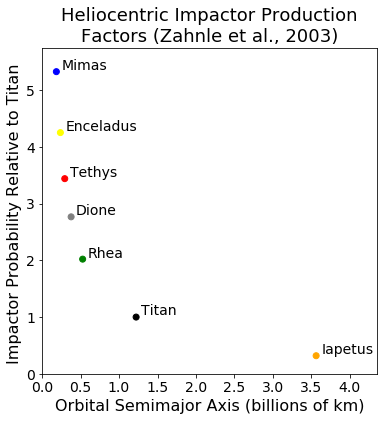

In [24]:
plt.figure(figsize=(6,6))
x = np.array([ro_mimas, ro_enceladus, ro_tethys, ro_dione, ro_rhea, ro_titan, ro_iapetus])/1e9
y = [pt_mimas, pt_enceladus, pt_tethys, pt_dione, pt_rhea, pt_titan, pt_iapetus]
names = ['Mimas','Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus']
colors = ['blue', 'yellow', 'red', 'gray', 'green', 'black', 'orange']
plt.scatter(x, y, c=colors)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i]),xytext=(5, 2), textcoords='offset points', size=14)
plt.xlim([0,4.35])
plt.ylim([0,5.75])
plt.xlabel('Orbital Semimajor Axis (billions of km)',size=16)
plt.ylabel('Impactor Probability Relative to Titan ',size=16)
plt.title('Heliocentric Impactor Production\nFactors (Zahnle et al., 2003)',size=18)
plt.xticks(size=14)
plt.yticks(size=14)
fig = plt.gcf()
fig.savefig('HeliocenticImpactorProbabilityFactors.pdf', bbox_inches='tight')

Initialize the functions that calculate the counting error PDFs from Poisson statistics.

In [88]:
#Upper bound, median, and lower bound, p=0.841345 is the cumulative percentage cutoff equivalent to 1 sigma
def ig_error(p,n):
    return gamma.ppf(1-p,n+1),gamma.ppf(0.5,n+1),gamma.ppf(p,n+1)
#Median value
def ig_50(n):
    return gamma.ppf(0.5,n+1)
#Lower bound
def ig_lower(n):
    return gamma.ppf(0.5,n+1)-gamma.ppf(1-0.841345,n+1)
#Upper bound
def ig_upper(n):
    return gamma.ppf(0.841345,n+1)-gamma.ppf(0.5,n+1)
#Full numerical PDF
def ig_ndist(n,increment_exponent):
    return np.array([gamma.ppf(p,n+1) for p in list(np.arange(0.1**increment_exponent,1.0,0.1**increment_exponent))])
#A brute force numerical calculation of the PDF without using the percent-point function of the gamma distribution
def poisson_error_bars(p,n,n_points=5000):
    nrange = max(n*10.0,10.0)
    inc = nrange/float(n_points)
    X = np.arange(0.5*inc,nrange,inc)
    Y = [poisson.pmf(n,m) for m in X]
    Yc = np.cumsum(Y)/len(X)*nrange
    cdfn = pd.DataFrame({'n':X,'cp':Yc})
    return [cdfn[cdfn['cp']<cp].iloc[-1]['n'] for cp in [1.0-p,0.5,p]]

Verifies that the percent-point function of the gamma distribution method reaches the same result as the brute force numerical inversion of the Poisson distribution, but much more efficiently.  To increase the accuracy of the brute force method, increase n_points.

In [91]:
t1=time.time()
print(poisson_error_bars(0.841345,1,n_points=5000))
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))
t1=time.time()
print(ig_error(0.841345,1))
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

[0.707, 1.6769999999999998, 3.297]
Run time: 0.5934
(0.7081847118202692, 1.6783469900166612, 3.299528644717541)
Run time: 0.0018


Initialize the numerical PDF and associated cumulative percentiles for an N=1 observation

In [95]:
t1=time.time()
n1_ndist = ig_ndist(1,4)
n1_percentiles = np.percentile(n1_ndist,np.arange(0.00005,100.0,0.00005))
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

Run time: 2.6698


Plot the PDF of an N=1 observation.  Shows the probability density of the expected number of craters from the true cratering rate from an observation of one crater.  Both linear and log scale plots.

Run time: 0.9159


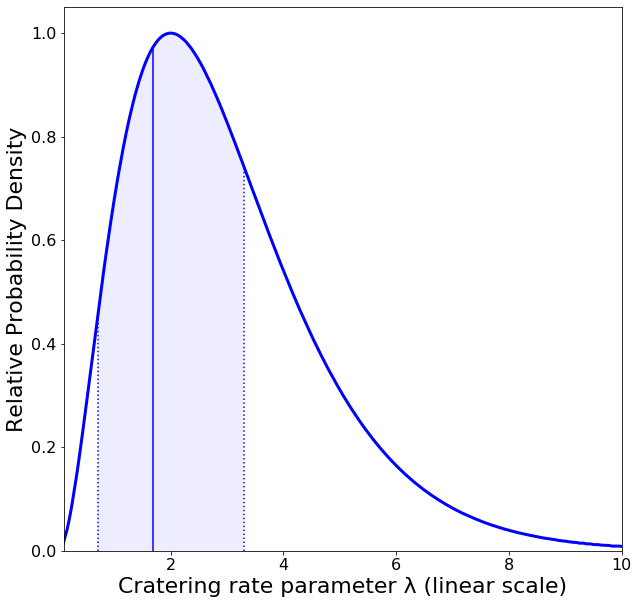

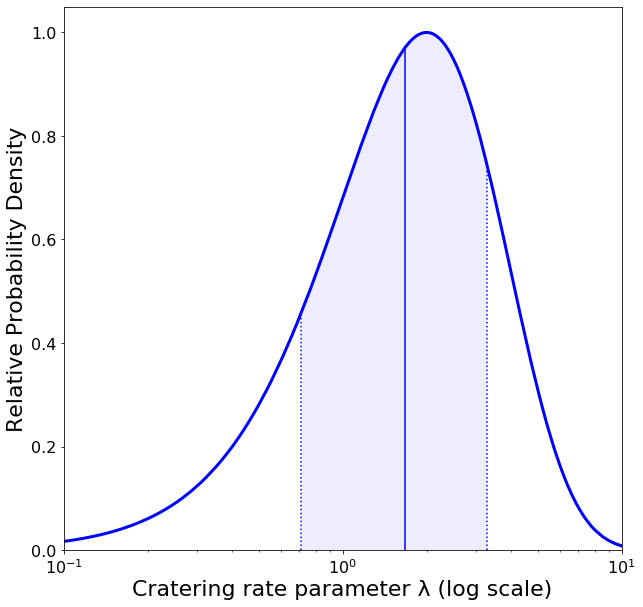

In [96]:
t1=time.time()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
Y,bin_edges=np.histogram(np.log10(n1_percentiles),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(n1_percentiles,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.07)
ax.plot([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.plot([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.plot([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Cratering rate parameter λ (linear scale)',size=22)
plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.1,10])
plt.ylim([0,1.05])
pfig = plt.gcf()
pfig.savefig('n1_PDF_linear.pdf',bbox_inches='tight')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
Y,bin_edges=np.histogram(np.log10(n1_percentiles),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(n1_percentiles,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.07)
ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Cratering rate parameter λ (log scale)',size=22)
plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.1,10])
plt.ylim([0,1.05])
pfig = plt.gcf()
pfig.savefig('n1_PDF_log.pdf',bbox_inches='tight')
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

Plot the impact velocities and scale factors for the different models.  Supplemental Figure B1.

Run time: 0.7032


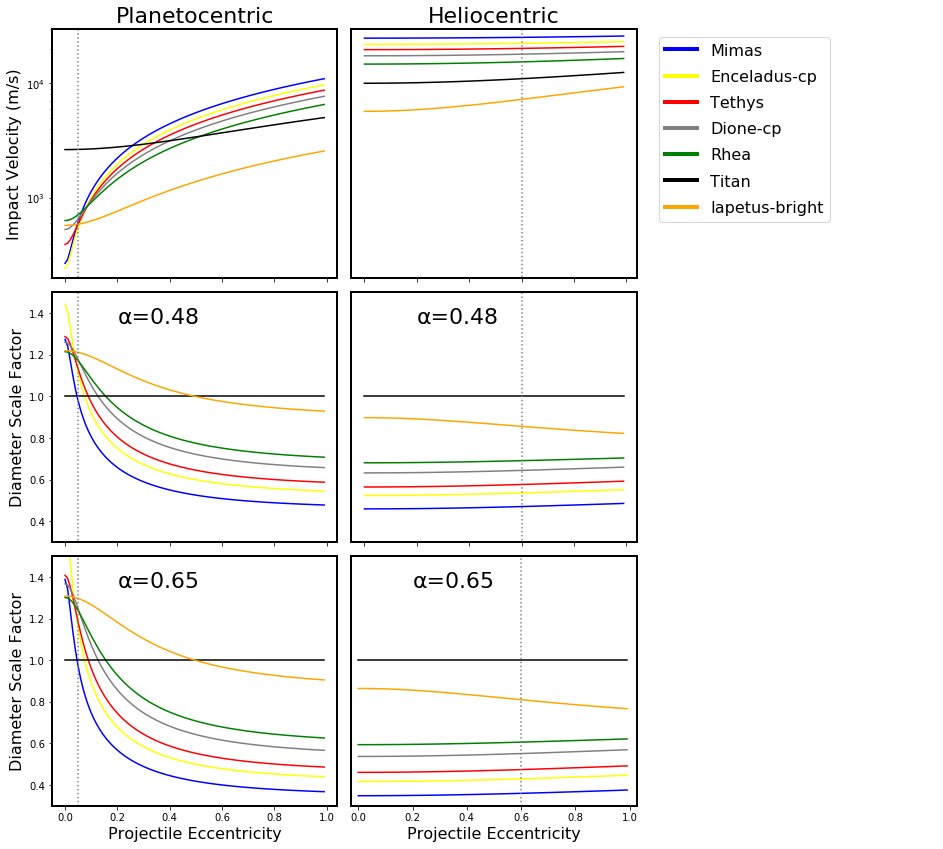

In [99]:
t1=time.time()
def V_moon(key,X,alpha):
    return [vi(ep, e_dict[key], m_dict[key], r_dict[key], ro_dict[key]) for ep in X]
def V_h_moon(key,X,alpha):
    return [vi_h(ep, e_dict[key], m_dict[key], r_dict[key], ro_dict[key]) for ep in X]
def Y_moon(key,X,alpha):
    return [d_scale_factor(ep, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha) for ep in X]
def Y_h_moon(key,X,alpha):
    return [d_scale_factor_h(ep, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha) for ep in X]

X = np.arange(0.0,1.0,0.01)

fig = plt.figure(figsize=(17.6/2*1.5,(14*1.5+2.8)/2))

ax = fig.add_subplot(331)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.semilogy(X,V_moon(key,X,0.65), color=color_dict[key], label=key.partition('-')[0])
plt.semilogy([0.05,0.05],[100,100000],':',color='gray')
plt.ylim([200,30000])
ax.get_xaxis().set_ticklabels([])
plt.ylabel('Impact Velocity (m/s)',size=16)
plt.title('Planetocentric',size=22)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(332)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.semilogy(X,V_h_moon(key,X,0.65), color=color_dict[key], label=key.partition('-')[0])
plt.semilogy([0.6,0.6],[100,100000],':',color='gray')
plt.ylim([200,30000])
ax.get_xaxis().set_ticklabels([])
plt.title('Heliocentric',size=22)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(334)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.plot(X,Y_moon(key,X,0.48), color=color_dict[key], label=key.partition('-')[0])
plt.plot([0.05,0.05],[0,2],':',color='gray')
plt.ylim([0.3,1.5])
plt.text(0.2,1.35,'α=0.48',fontsize=22)
ax.get_xaxis().set_ticklabels([])
plt.ylabel('Diameter Scale Factor',size=16)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(335)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.plot(X,Y_h_moon(key,X,0.48), color=color_dict[key], label=key.partition('-')[0])
plt.plot([0.6,0.6],[0,2],':',color='gray')
plt.ylim([0.3,1.5])
plt.text(0.2,1.35,'α=0.48',fontsize=22)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.get_xaxis().set_ticklabels([])
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(337)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.plot(X,Y_moon(key,X,0.65), color=color_dict[key], label=key.partition('-')[0])
plt.plot([0.05,0.05],[0,2],':',color='gray')
plt.ylim([0.3,1.5])
plt.text(0.2,1.35,'α=0.65',fontsize=22)
plt.xlabel('Projectile Eccentricity',size=16)
plt.ylabel('Diameter Scale Factor',size=16)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(338)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.plot(X,Y_h_moon(key,X,0.65), color=color_dict[key], label=key.partition('-')[0])
plt.plot([0.6,0.6],[0,2],':',color='gray')
plt.xlim([-0.025,1.025])
plt.ylim([0.3,1.5])
plt.text(0.2,1.35,'α=0.65',fontsize=22)
plt.xlabel('Projectile Eccentricity',size=16)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(333)
custom_lines = [Line2D([0], [0], color=color_dict[key], lw=4) for key in cp_keys]
custom_lines.insert(5,Line2D([0], [0], color='Black', lw=4))
ax.legend(custom_lines, cp_keys[:5] + ['Titan'] + [cp_keys[5]],labelspacing=0.7, fontsize=16, loc=2)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_xaxis().set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(wspace=0.02)
fig.subplots_adjust(hspace=0.02)

plt.tight_layout()

fig.savefig('ScaleFactorPanelFigure.pdf')

t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

Define the bins, define the Titan data from Neish et al. (2012) with Ganesa Macula added, bin the Titan data.  The "prob" numbers are area adjustments from detection probabilities calculated by Neish et al. (2012) from Monte Carlo modeling.

In [100]:
t1=time.time()
bins = [2.0*(math.sqrt(2.0)**n) for n in list(range(5,17))]
titan_ds = pd.read_csv('titan_data.csv').astype('float')
titan_gmeans_d = np.zeros(len(bins)-1)
n_d = np.zeros(len(bins)-1)
for i in list(range(len(bins)-1)):
    bin_craters = titan_ds[(titan_ds['D'] >= bins[i]) & (titan_ds['D'] < bins[i+1])]
    n = bin_craters.shape[0]
    n_d[i] = n
    if n!=0:
        titan_gmeans_d[i] = gmean(bin_craters['D'].tolist())
full_bins = [2.0*(math.sqrt(2.0)**n) for n in list(range(1,17))]
full_bin_gmeans = [gmean([full_bins[i],full_bins[i+1]]) for i in list(range(len(full_bins)-1))]
prob8 = 58.3 + (gmean([bins[8],bins[9]]) - gmean([bins[7],bins[8]]))*(76.0-58.3)/(gmean([bins[10],bins[11]]) - gmean([bins[7],bins[8]]))
prob9 = 58.3 + (gmean([bins[10],bins[9]]) - gmean([bins[7],bins[8]]))*(76.0-58.3)/(gmean([bins[10],bins[11]]) - gmean([bins[7],bins[8]]))
titan_counts = pd.DataFrame({'count':[2,11,5,8,2,4,2,2,0,0,1],'prob':[33.0,33.0,33.0,41.4,46.4,50.0,53.7,58.3,\
            prob8,prob9,76.0]}, index=titan_gmeans_d)
titan_counts = titan_counts[titan_counts['count']!=0]
titan_counts.sort_index(ascending=False, inplace=True)
area_titan = 4*math.pi*r_titan**2/10.0**6
titan_density = ((titan_counts['count']/titan_counts['prob']*100.0).cumsum()/100*titan_counts['prob'])\
            .apply(ig_50)/100*titan_counts['prob']/area_titan
titan_lower = ((titan_counts['count']/titan_counts['prob']*100.0).cumsum()/100*titan_counts['prob'])\
            .apply(ig_lower)/100*titan_counts['prob']/area_titan
titan_upper = ((titan_counts['count']/titan_counts['prob']*100.0).cumsum()/100*titan_counts['prob'])\
            .apply(ig_upper)/100*titan_counts['prob']/area_titan
titan_ndist = ((titan_counts['count']/titan_counts['prob']*100.0).cumsum()/100*titan_counts['prob'])\
            .apply(lambda var: ig_ndist(var,3.5))/100*titan_counts['prob']/area_titan
titan_data = pd.DataFrame({'density':titan_density.values, 'lower':titan_lower.values, \
            'upper':titan_upper.values, 'ndist':titan_ndist.values, 'D':list(titan_density.index.values)})
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

Run time: 6.5166


Define the function that calculates the crater count bins for each terrain, saving them as a dictionary for each model.

In [101]:
def get_binned_dict(alpha, model='planetocentric'):
    return_dict = {}
    if model == 'unscaled':
        key_list = keys
        full_bins = [2.0*(math.sqrt(2.0)**n) for n in list(np.arange(1,17,0.5))]
    else:
        key_list = cp_keys
        full_bins = [2.0*(math.sqrt(2.0)**n) for n in list(range(1,17))]
    full_bin_gmeans = [gmean([full_bins[i],full_bins[i+1]]) for i in list(range(len(full_bins)-1))]
    for key in key_list:
        area = cp_dict_full[key]['Area (km^2)'][0]
        full_area = r_dict[body_dict[key]]**2 * math.pi * 4 /1000000.0
        if model=='planetocentric':
            sf = d_scale_factor(0.05, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha)
        if model in ['heliocentric', 'heliocentric-unadjusted']:
            sf = d_scale_factor_h(0.6, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha)
        if model == 'unscaled':
            sf = 1.0
        else:
            NameError('Bad model name')
        if model=='heliocentric': 
            pt = pt_dict[key]
        else:
            pt = 1.0
        if model != 'unscaled':
            cp_dict_calc = cp_dict.copy()
        else:
            cp_dict_calc = cp_dict_full.copy()
        cp_dict_calc[key] = cp_dict_calc[key].assign(D_sf=cp_dict_calc[key]['D (km)']*sf).sort_values(by='D_sf', \
                                                                                                ascending=False)
        min_d = cp_dict_calc[key]['D_sf'].min()
        if model == 'unscaled':
            min_d = cp_dict_calc[key]['D (km)'].min()
        n_d = list(np.zeros(len(full_bin_gmeans)))
        gmeans_d = list(np.zeros(len(full_bin_gmeans)))
        binned_d = list(np.zeros(len(full_bin_gmeans)))
        binned_l = list(np.zeros(len(full_bin_gmeans)))
        binned_u = list(np.zeros(len(full_bin_gmeans)))
        binned_ndist = list(np.zeros(len(full_bin_gmeans)))
        for i in list(range(len(full_bins)-1)):
            if full_bins[i] >= min_d:
                bin_craters = cp_dict_calc[key][(cp_dict_calc[key]['D_sf'] >= full_bins[i]) & \
                                                (cp_dict_calc[key]['D_sf'] < full_bins[i+1])]
                n = bin_craters.shape[0]
                n_d[i] = n
                if n!=0:
                    gmeans_d[i] = gmean(bin_craters['D_sf'].tolist())
            else:
                n_d[i] = 1000000000000
        n_d.reverse()
        n_d = list(np.cumsum(n_d))
        n_d.reverse()
        i_e = 3.5
        for i in list(range(len(n_d))):
            if n_d[i] > 500000000000.0 or n_d[i]==0:
                binned_d[i] = None
            else:
                if key in ['Mimas','Tethys','Dione-cp','Rhea']:
                    af = area/full_area
                elif key == 'Iapetus-bright':
                    af = 4*area/full_area
                elif key == 'Enceladus-cp':
                    af = 0
                else:
                    NameError('Wrong key name')
                binned_d[i] = ig_50(n_d[i] + af)/area/pt
                binned_l[i] = ig_lower(n_d[i] + af)/area/pt
                binned_u[i] = ig_upper(n_d[i] + af)/area/pt
                binned_ndist[i] = ig_ndist(n_d[i] + af, i_e)/area/pt
        big_D_dict = {'Mimas':[139.0], 'Tethys':[445.0], 'Dione-cp':[350],'Rhea':[480],'Iapetus-bright':[580.0,504.0,445.0,424.0]}
        if key in big_D_dict.keys():
            for i in list(range(len(big_D_dict[key]))):
                gmeans_d.append(big_D_dict[key][i] * sf)
                binned_d.append(ig_50(float(i+1))/full_area/pt)
                binned_l.append(ig_lower(float(i+1))/full_area/pt)
                binned_u.append(ig_upper(float(i+1))/full_area/pt)
                binned_ndist.append(ig_ndist(1.0,i_e)/full_area/pt)
        bin_df = pd.DataFrame({'D_sf':gmeans_d, 'density_sf':binned_d, 'lower_sf':binned_l, 'upper_sf':binned_u, 'ndist_sf':binned_ndist})
        return_dict[key] = bin_df[~(bin_df['density_sf'].isnull()|bin_df['D_sf'].isnull()|(bin_df['D_sf'] == 0.0))]
    return return_dict

Calculate the binned data dictionaries for each model and each value of alpha.  This can take a long time to run, so there is a default option to load from a saved file.

In [106]:
t1=time.time()
if False:
    binned_dict_p48 = get_binned_dict(0.48,model='planetocentric')
    binned_dict_h48 = get_binned_dict(0.48,model='heliocentric')
    binned_dict_p65 = get_binned_dict(0.65,model='planetocentric')
    binned_dict_h65 = get_binned_dict(0.65,model='heliocentric')
    binned_dict_unscaled = get_binned_dict(9999.0,model='unscaled')#The alpha value is not used in the unscaled model
    pkl.dump( binned_dict_p48, open('binned_dict_p48.pkl', 'wb'))
    pkl.dump( binned_dict_h48, open('binned_dict_h48.pkl', 'wb'))
    pkl.dump( binned_dict_p65, open('binned_dict_p65.pkl', 'wb'))
    pkl.dump( binned_dict_h65, open('binned_dict_h65.pkl', 'wb'))
    pkl.dump( binned_dict_unscaled, open('binned_dict_unscaled.pkl', 'wb'))
else:
    binned_dict_p48 = pkl.load(open('binned_dict_p48.pkl', 'rb'))
    binned_dict_h48 = pkl.load(open('binned_dict_h48.pkl', 'rb'))
    binned_dict_p65 = pkl.load(open('binned_dict_p65.pkl', 'rb'))
    binned_dict_h65 = pkl.load(open('binned_dict_h65.pkl', 'rb'))
    binned_dict_unscaled = pkl.load(open('binned_dict_unscaled.pkl', 'rb'))
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

Run time: 0.0233


Calculate the minimum diameter cutoff table.  Supplemental Table A1.

In [108]:
min_d_h48 = [round(pd.Series(full_bins)[pd.Series(full_bins) < \
                binned_dict_h48[key]['D_sf'].min()].max()/d_scale_factor_h_key(0.6,key,0.48),2) for key in cp_keys]
min_d_h65 = [round(pd.Series(full_bins)[pd.Series(full_bins) < \
                binned_dict_h65[key]['D_sf'].min()].max()/d_scale_factor_h_key(0.6,key,0.65),2) for key in cp_keys]
min_d_p48 = [round(pd.Series(full_bins)[pd.Series(full_bins) < \
                binned_dict_p48[key]['D_sf'].min()].max()/d_scale_factor_key(0.05,key,0.48),2) for key in cp_keys]
min_d_p65 = [round(pd.Series(full_bins)[pd.Series(full_bins) < \
                binned_dict_p65[key]['D_sf'].min()].max()/d_scale_factor_key(0.05,key,0.65),2) for key in cp_keys]
min_d_table = pd.DataFrame({'min_d_p65':min_d_p65,'min_d_p48':min_d_p48,\
              'min_d_h65':min_d_h65,'min_d_h48':min_d_h48},index=cp_keys)
min_d_table.to_csv('min_d_table.csv')
print('Mean diameter cutoff: ' + str(min_d_table.mean().mean()))
min_d_table

Mean diameter cutoff: 12.52625


,min_d_p65,min_d_p48,min_d_h65,min_d_h48
Mimas,11.65,11.56,11.11,12.03
Enceladus-cp,13.81,10.15,13.17,10.56
Tethys,13.51,14.12,11.93,13.88
Dione-cp,12.82,13.58,10.26,12.42
Rhea,12.92,13.66,13.20,11.58
Iapetus-bright,12.33,13.20,13.96,13.22


Define the functions used for probabilistic linear and piecewise regression from PDFs.

In [134]:
def find_line_i(input_tuple):
    x,y_ndist = input_tuple
    y = list(y_ndist.apply(random.choice).apply(log))
    m,b,r,p,stderr = linregress(x,y)
    return (m,b)

def get_lines(binned_dict,key,n,low=0, high=99999999999999.0):
    x = list(binned_dict[key][(binned_dict[key]['D_sf'] > low) & \
                              (binned_dict[key]['D_sf'] < high)]['D_sf'].apply(log))
    y_ndist = binned_dict[key][(binned_dict[key]['D_sf'] > low) & (binned_dict[key]['D_sf'] < high)]['ndist_sf']
    input_list = [(x,y_ndist) for i in range(n)]
    with Pool(5) as pool:
        lrs = pool.map(find_line_i, input_list)
        pool.close()
    return pd.DataFrame(lrs,columns=['m','b'])

def piecewise_linear(x, x0, y0, k2):
    k1=-1.83
    #k2=-2.5
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def piecewise_linear_fixed(x, x0, y0):
    k1=-1.83
    k2=-2.5
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def find_piecewise_i(input_tuple):
    x,y_ndist = input_tuple
    y = list(y_ndist.apply(random.choice).apply(log))
    p , e = optimize.curve_fit(piecewise_linear, x, y)
    return tuple(p)

def get_piecewise_lines(binned_dict,key,n):
    x = list(binned_dict[key][binned_dict[key]['D_sf']<100]['D_sf'].apply(log))
    y_ndist = binned_dict[key][binned_dict[key]['D_sf']<100]['ndist_sf']
    input_list = [(x,y_ndist) for i in range(n)]
    with Pool(5) as pool:
        lrs = pool.map(find_piecewise_i, input_list)
        pool.close()
    return pd.DataFrame(lrs,columns=['x_ip','y_ip','k2'])

def find_piecewise_i_fixed(input_tuple):
    x,y_ndist = input_tuple
    y = list(y_ndist.apply(random.choice).apply(log))
    p , e = optimize.curve_fit(piecewise_linear_fixed, x, y)
    return tuple(p)

def get_piecewise_lines_fixed(binned_dict,key,n):
    x = list(binned_dict[key][binned_dict[key]['D_sf']<100]['D_sf'].apply(log))
    y_ndist = binned_dict[key][binned_dict[key]['D_sf']<100]['ndist_sf']
    input_list = [(x,y_ndist) for i in range(n)]
    with Pool(5) as pool:
        lrs = pool.map(find_piecewise_i_fixed, input_list)
        pool.close()
    return pd.DataFrame(lrs,columns=['x_ip','y_ip'])

Calculate the piecewise fits for both the free slope and fixed slope cases for Mimas, Tethys, and Dione.

In [137]:
t1=time.time()
n_fits = 10000
tethys_piecewise = get_piecewise_lines(binned_dict_unscaled,'Tethys',n_fits)
dione_piecewise = get_piecewise_lines(binned_dict_unscaled,'Dione-cp',n_fits)
mimas_piecewise = get_piecewise_lines(binned_dict_unscaled,'Mimas',n_fits)
t2=time.time()
print('Free slope run time: ' + str(round(t2-t1,4)))

t1=time.time()
n_fits = 10000
tethys_piecewise_fixed = get_piecewise_lines_fixed(binned_dict_unscaled,'Tethys',n_fits)
dione_piecewise_fixed = get_piecewise_lines_fixed(binned_dict_unscaled,'Dione-cp',n_fits)
mimas_piecewise_fixed = get_piecewise_lines_fixed(binned_dict_unscaled,'Mimas',n_fits)
t2=time.time()
print('Fixed slope run time: ' + str(round(t2-t1,4)))

Run time: 21.4381


Define the functions to plot the free and fixed slope fits

In [163]:
def plot_unscaled_fit_free(key,fit):
    binned_dict = binned_dict_unscaled
    fig = plt.figure()
    binned_dict[key].plot(y='density_sf',x='D_sf', \
                          yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                          logx=True, logy=True, kind='scatter', 
                          color=color_dict[body_dict[key]], legend=True, s=50, figsize=(10,10))
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.ylabel('Cumulative Crater Density',size=18)
    plt.xlabel('Unscaled Crater Diameter (km)',size=18)
    custom_lines = [Line2D([0], [0], color=color_dict[body_dict[key]], lw=8)]
    plt.legend(custom_lines, [key],labelspacing=0.7, fontsize=22, loc=1)
    xd = np.linspace(0.5, 3, 100)
    xip,yip,k2 = tuple(fit.median().tolist())
    print(key + ' median slope: ' + str(round(k2,3)))
    print(key + ' median inflection point: ' + str(round(10**xip,3)))
    plt.plot(10**xd, 10**piecewise_linear(xd,xip,yip,k2),'gray')
    plt.plot(10**xd, 10**(-1*k2*xip + yip + k2*xd),'gray',linestyle='--')
    plt.plot(10**xd, 10**(1.83*xip + yip - 1.83*xd),'gray',linestyle='--')
    plt.xlim([3,900])
    plt.ylim([0.8*10.0**-7,10.0**-2])
    fig=plt.gcf()
    fig.savefig(key.partition('-')[0] + 'FitFree.pdf', bbox_inches='tight')

def plot_unscaled_fit_fixed(key,fit):
    binned_dict = binned_dict_unscaled
    fig = plt.figure()
    binned_dict[key].plot(y='density_sf',x='D_sf', \
                          yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                          logx=True, logy=True, kind='scatter', 
                          color=color_dict[body_dict[key]], legend=True, s=50, figsize=(10,10))
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.ylabel('Cumulative Crater Density',size=18)
    plt.xlabel('Unscaled Crater Diameter (km)',size=18)
    custom_lines = [Line2D([0], [0], color=color_dict[body_dict[key]], lw=8)]
    plt.legend(custom_lines, [key],labelspacing=0.7, fontsize=22, loc=1)
    xd = np.linspace(0.5, 3, 100)
    xip,yip = fit['x_ip'].median(),fit['y_ip'].median()
    print(key +' median inflection point: ' + str(round(10**xip,3)))
    plt.plot(10**xd, 10**piecewise_linear_fixed(xd,xip,yip),'gray')
    plt.plot(10**xd, 10**(2.5*xip + yip - 2.5*xd),'gray',linestyle='--')
    plt.plot(10**xd, 10**(1.83*xip + yip - 1.83*xd),'gray',linestyle='--')
    plt.xlim([3,900])
    plt.ylim([0.8*10.0**-7,10.0**-2])
    fig=plt.gcf()
    fig.savefig(key.partition('-')[0] + 'Fit.pdf', bbox_inches='tight')

Plot the fixed and free slope fits for Mimas, Tethys, and Dione.  Supplemental Figures F1-F6

Mimas median inflection point: 12.135
Tethys median inflection point: 11.089
Dione-cp median inflection point: 12.312
Mimas median slope: -2.736
Mimas median inflection point: 15.764
Tethys median slope: -2.502
Tethys median inflection point: 11.18
Dione-cp median slope: -2.466
Dione-cp median inflection point: 11.721


<Figure size 432x288 with 0 Axes>

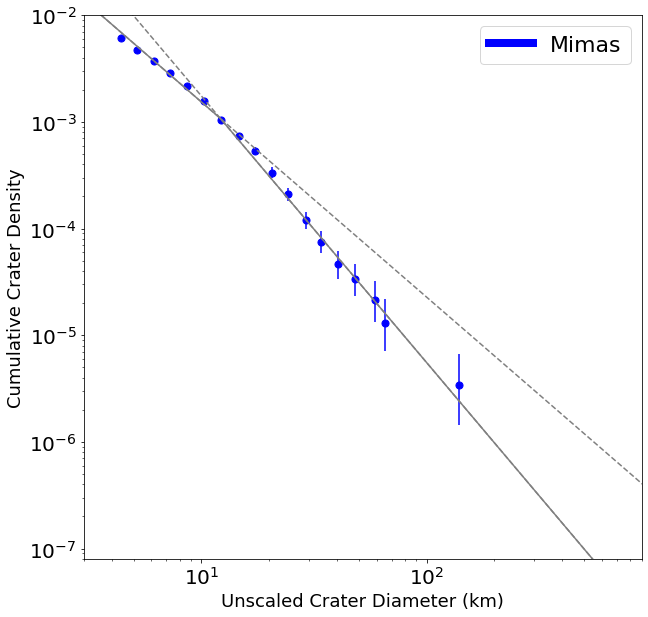

<Figure size 432x288 with 0 Axes>

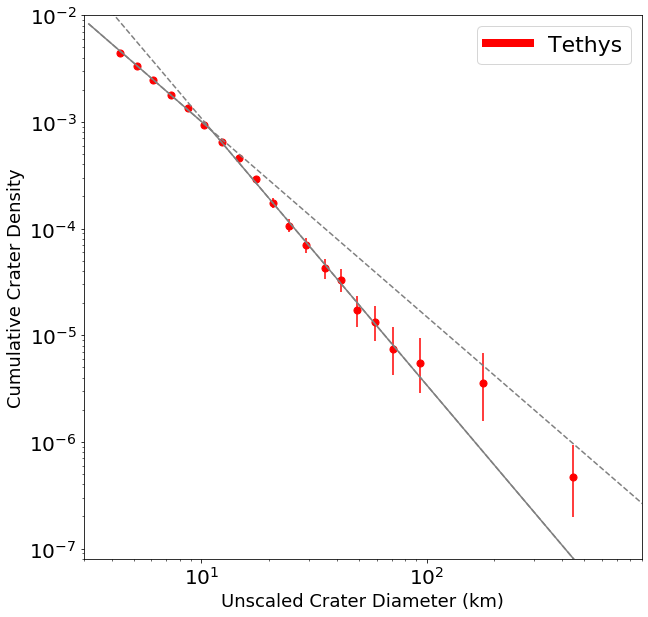

<Figure size 432x288 with 0 Axes>

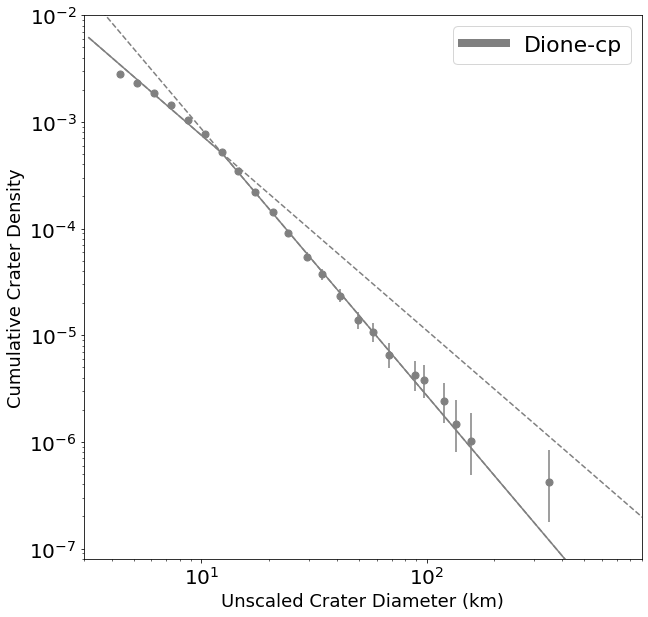

<Figure size 432x288 with 0 Axes>

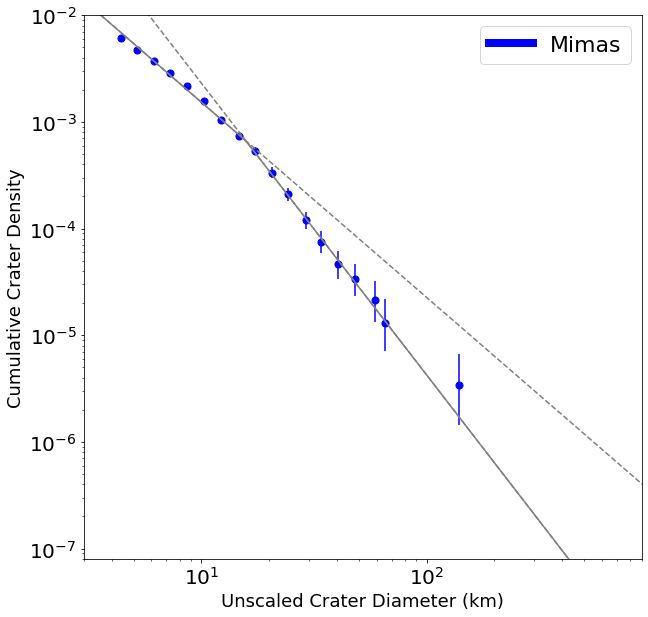

<Figure size 432x288 with 0 Axes>

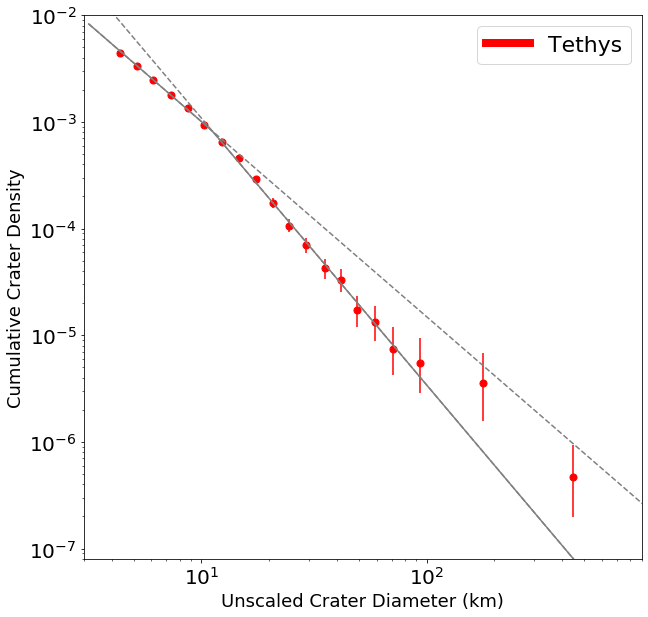

<Figure size 432x288 with 0 Axes>

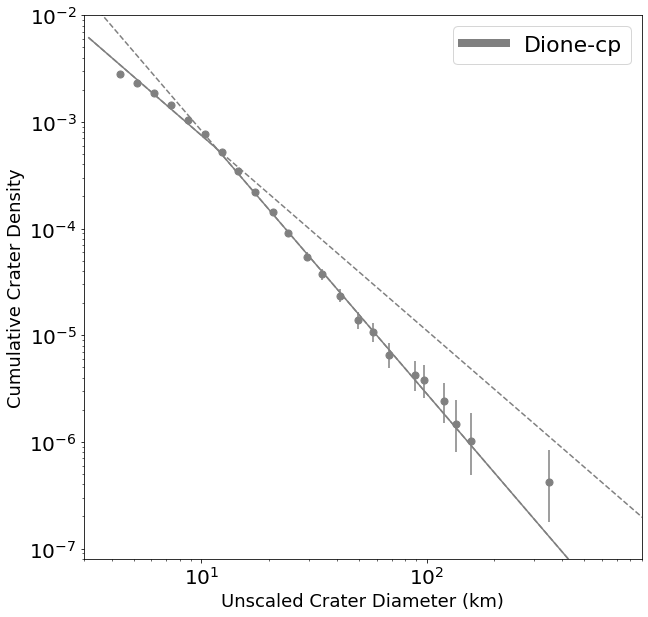

In [164]:
plot_unscaled_fit_fixed('Mimas',mimas_piecewise_fixed)
plot_unscaled_fit_fixed('Tethys',tethys_piecewise_fixed)
plot_unscaled_fit_fixed('Dione-cp',dione_piecewise_fixed)
plot_unscaled_fit_free('Mimas',mimas_piecewise)
plot_unscaled_fit_free('Tethys',tethys_piecewise)
plot_unscaled_fit_free('Dione-cp',dione_piecewise)

Calculate and plot a linear fit for Iapetus excluding the basins.  Supplemental Figure F7.

b: -1.4338614366496412
m lower bound: -1.6466437199252733
m median: -1.7620300670561948
m upper bound: -1.8942079911923888
Run time: 4.3017


<Figure size 432x288 with 0 Axes>

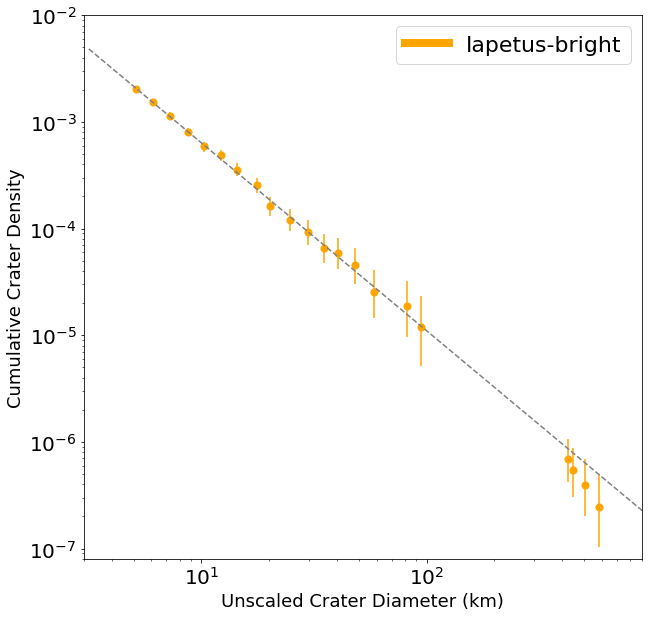

In [161]:
t1=time.time()
n_fits = 10000
iapetus_no_basins_lines = get_lines(binned_dict_unscaled,'Iapetus-bright',n_fits,high=200.0)
iapetus_no_basins_slopes = np.array(iapetus_no_basins_lines['m'].tolist())
iapetus_no_basins = iapetus_no_basins_lines.median()
print('b: ' + str(iapetus_no_basins['b']))
m_bounds = np.percentile(iapetus_no_basins_slopes,[84.1345,50,100.0-84.1345])
print('m lower bound: ' + str(m_bounds[0]))
print('m median: ' + str(m_bounds[1]))
print('m upper bound: ' + str(m_bounds[2]))

binned_dict = binned_dict_unscaled
fig = plt.figure()
key='Iapetus-bright'
binned_dict[key].plot(y='density_sf',x='D_sf', \
                      yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                      logx=True, logy=True, kind='scatter', 
                      color=color_dict[body_dict[key]], legend=True, s=50, figsize=(10,10))
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('Cumulative Crater Density',size=18)
plt.xlabel('Unscaled Crater Diameter (km)',size=18)
custom_lines = [Line2D([0], [0], color=color_dict[body_dict[key]], lw=8)]
plt.legend(custom_lines, [key],labelspacing=0.7, fontsize=22, loc=1)
xd = np.linspace(0.5, 3, 100)
m,b = tuple(iapetus_no_basins.tolist())
plt.plot(10**xd, 10**(m*xd + b),'gray',linestyle='--')
plt.xlim([3,900])
plt.ylim([0.8*10.0**-7,10.0**-2])
fig=plt.gcf()
fig.savefig('IapetusNoBasinFit.pdf', bbox_inches='tight')
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

Plot the Dione cratered plains data and fit alongside the Dione smooth plains data.  Evidence that the inflection point in the cratered plains data is due to equilibrium saturation because it does not show up on unsaturated terrains.  Supplemental Figure G1.

<Figure size 432x288 with 0 Axes>

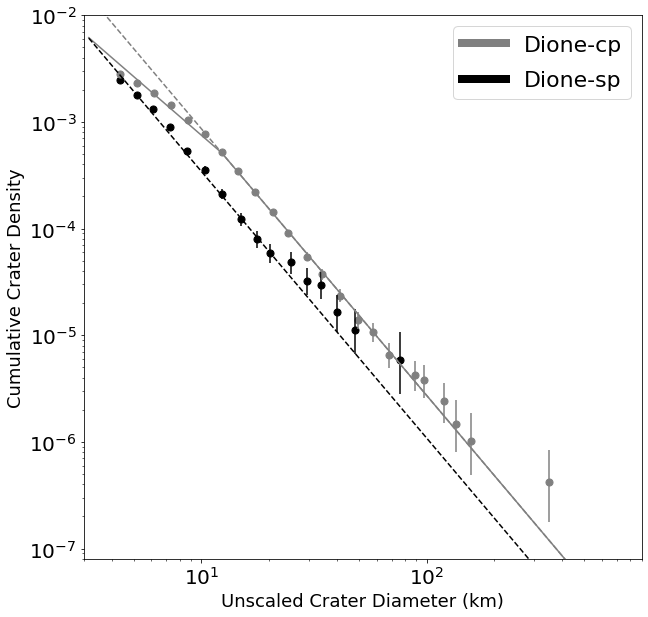

In [165]:
binned_dict = binned_dict_unscaled
fig = plt.figure()
key='Dione-sp'
ax=binned_dict[key].plot(y='density_sf',x='D_sf', \
                      yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                      logx=True, logy=True, kind='scatter', 
                      color='Black', legend=True, s=50, figsize=(10,10))
key='Dione-cp'
binned_dict[key].plot(y='density_sf',x='D_sf', \
                      yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                      logx=True, logy=True, kind='scatter', 
                      color=color_dict[body_dict[key]], legend=True, s=50, figsize=(10,10),ax=ax)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('Cumulative Crater Density',size=18)
plt.xlabel('Unscaled Crater Diameter (km)',size=18)
custom_lines = [Line2D([0], [0], color=color, lw=8) for color in ['gray','black']]
ax.legend(custom_lines, ['Dione-cp','Dione-sp'],labelspacing=0.7, fontsize=22, loc=1)
xd = np.linspace(0.5, 3, 100)
xip,yip = dione_piecewise_fixed['x_ip'].median(),dione_piecewise_fixed['y_ip'].median()
plt.plot(10**xd, 10**piecewise_linear_fixed(xd,xip,yip),'gray')
plt.plot(10**xd, 10**(2.5*xip + yip - 2.5*xd),'gray',linestyle='--')
plt.plot(10**xd, 10**(-0.4 + 2.5*xip + yip - 2.5*xd),'k',linestyle='--')
plt.xlim([3,900])
plt.ylim([0.8*10.0**-7,10.0**-2])
fig=plt.gcf()
fig.savefig('DioneSaturation.pdf', bbox_inches='tight')

Plot the scaled heliocentric and planetocentric data for all the moons and both values of alpha.  Figure 1.

Run time: 5.9738


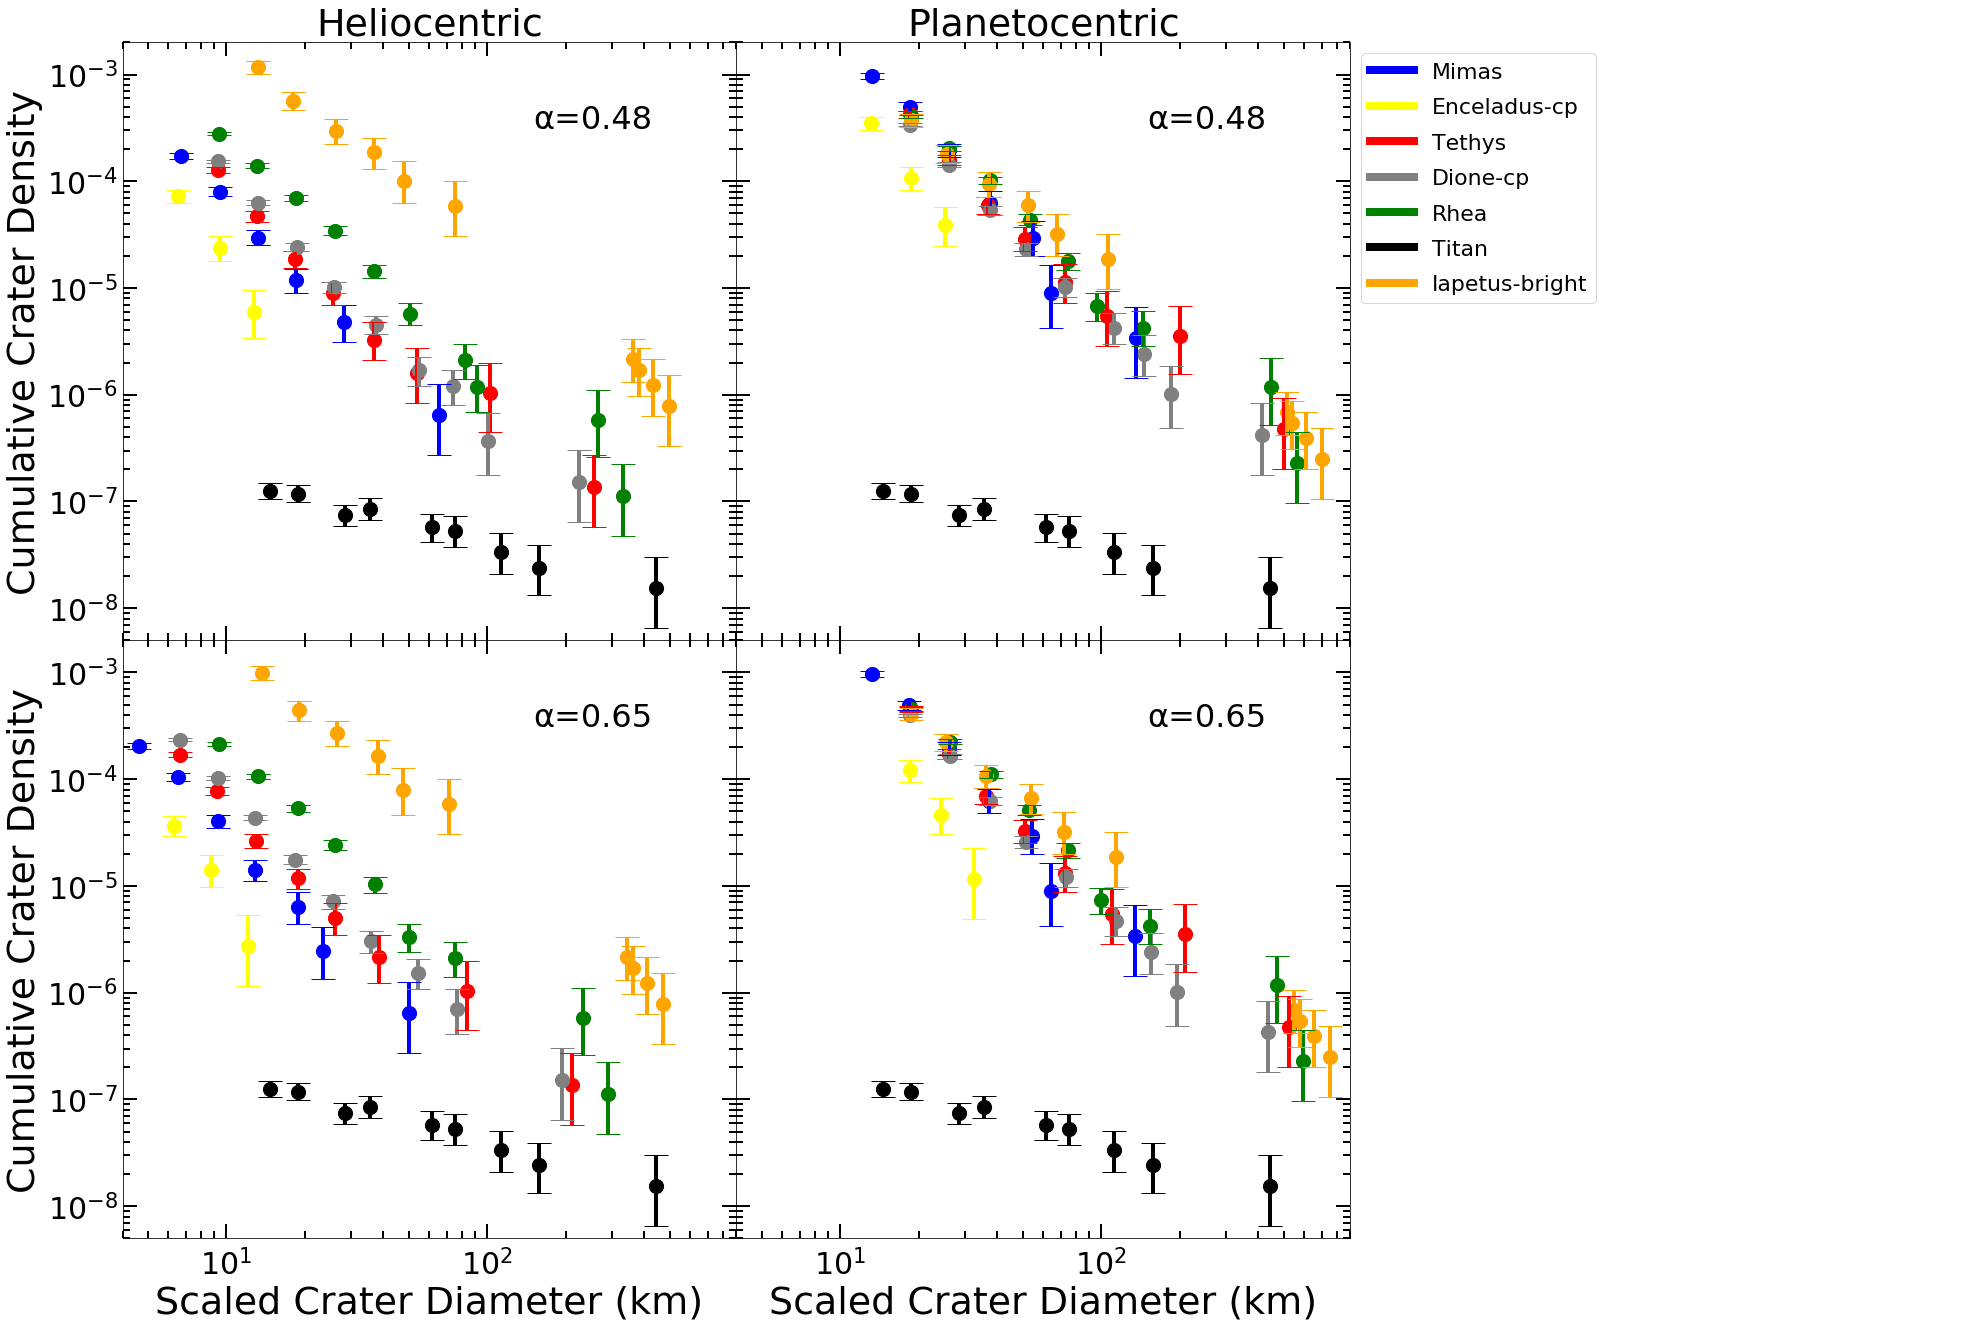

In [167]:
t1=time.time()
plt.rcParams['errorbar.capsize'] = 12
title_list = ['Heliocentric','Planetocentric','','','','']
binned_dict_list = [binned_dict_h48,binned_dict_p48,'',binned_dict_h65,binned_dict_p65,'']
fig = plt.figure(figsize=(33,22))
for i in list(range(6)):
    if i%3!=2:
        ax = fig.add_subplot(231 + i)
        binned_dict = binned_dict_list[i]
        plt.rcParams['errorbar.capsize'] = 12
        plt.rcParams['lines.linewidth'] = 4
        ax = binned_dict['Tethys'].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter', legend=True, ax=ax)
        for key in cp_keys:
            binned_dict[key].plot(y='density_sf',x='D_sf', \
                              yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                              logx=True, logy=True, kind='scatter', 
                              ax=ax, color=color_dict[key], legend=True, s=200)
        titan_data.plot(y='density', x='D', yerr=np.array([titan_data[['lower','upper']].values.transpose()]), \
                        color='black', logx=True, logy=True, kind='scatter', ax=ax, s=200)
        plt.xticks(size=30)
        if i%3==0:
            plt.yticks(size=30)
            plt.ylabel('Cumulative Crater Density',size=38)
        else:
            ax.get_yaxis().set_ticklabels([])
            plt.ylabel('',size=1)
        plt.xlabel('Scaled Crater Diameter (km)',size=38)
        plt.title(title_list[i],size=38)
        plt.xlim([4,900])
        plt.ylim([5*10.0**-9,2*10.0**-3])
        if i < 3:
            plt.text(150,10**-3.5,'α=0.48',fontsize=32)
        else:
            plt.text(150,10**-3.5,'α=0.65',fontsize=32)
    elif i==2:
        ax = fig.add_subplot(231 + i)
        custom_lines = [Line2D([0], [0], color=color_dict[key], lw=8) for key in cp_keys]
        custom_lines.insert(5,Line2D([0], [0], color='Black', lw=8))
        ax.legend(custom_lines, cp_keys[:5] + ['Titan'] + [cp_keys[5]],labelspacing=0.7, fontsize=22, loc=2)
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticklabels([])
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=14, width=2)
    ax.get_xaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_yaxis().set_tick_params(length=14, width=2)
    ax.get_yaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_xaxis().set_ticks_position('both')
    ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(pad=10, which='both')
    ax.get_yaxis().set_tick_params(pad=5, which='both')
    
fig.subplots_adjust(wspace=0,hspace=0)

pfig = plt.gcf()
pfig.savefig('CraterCountsPanel.pdf',bbox_inches='tight')
plt.rcParams['lines.linewidth'] = 1
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

Define a function to calculate the a probabilistic linear fit to the Titan PDFs

In [169]:
def get_titan_lines(n):
    data = pd.DataFrame(titan_data['D'])
    x = list(titan_data['D'].apply(log))
    lrs = []
    for i in list(range(n)):
        data = data.assign(y = titan_data['ndist'].apply(random.choice))
        y = list(data['y'].apply(log))
        m,b,r,p,stderr = linregress(x,y)
        lrs.append((m,b))
    return pd.DataFrame(lrs,columns=['m','b'])

Run this function

In [170]:
t1 = time.time()
titan_lines = get_titan_lines(1000)
t2=time.time()
print('Run time: ' + str(round(t2-t1,4)))

Run time: 1.7221


Visualization of how the probabilistic linear fit to PDFs works.  Shows one step with random samples of the PDFs.

<Figure size 432x288 with 0 Axes>

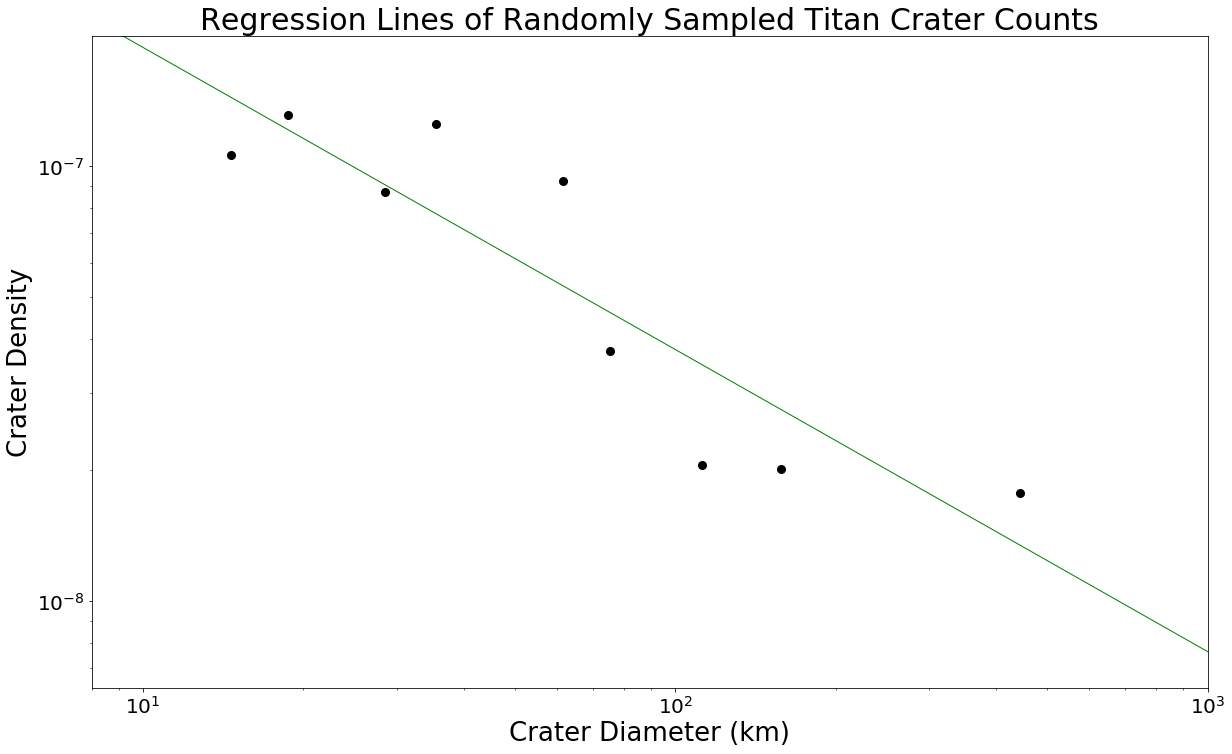

In [171]:
fig = plt.figure()
titan_data.plot(y='density', x='D', yerr=(titan_data[['lower','upper']].values.transpose()), color='white', \
                logx=True, logy=True, kind='scatter',figsize=(20,12), ylim=[10**-8.2,10**-6.7], xlim=[8,1000])
data = pd.DataFrame(titan_data['D'])
x = list(titan_data['D'].apply(log))
for i in range(1):
    data = data.assign(y = titan_data['ndist'].apply(random.choice))
    y = list(data['y'].apply(log))
    m,b,r,p,stderr = linregress(x,y)
    xmin=8
    xmax=1000
    plt.plot([xmin,xmax],[10**(b + m*log(xmin)), 10**(b + m*log(xmax))],'g')
    plt.plot(10**np.array(x),10**np.array(y),'ko',markersize=8)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Crater Diameter (km)',size=26)
plt.ylabel('Crater Density',size=26)
plt.title('Regression Lines of Randomly Sampled Titan Crater Counts',size=30)
fig=plt.gcf()
fig.savefig('RandomSample1.pdf', bbox_inches='tight')

Define functions used in making calculations behind the plots.

In [487]:
def get_percentile(lines,x,p):
    vlist = [line.m*x + line.b for line in lines.itertuples()]
    return np.percentile(vlist,p)

def plot_moon_lines(binned_dict,key,n,ax = 'None',do_legend = True):
    moon_lines = get_lines(binned_dict,key,n)
    xe = np.arange(0.5,3,0.01)
    mtitan = [10**get_percentile(titan_lines,xei,50.0) for xei in xe]
    utitan = [10**get_percentile(titan_lines,xei,84.1345) for xei in xe]
    ltitan = [10**get_percentile(titan_lines,xei,100.0-84.1345) for xei in xe]
    mmoon = [10**get_percentile(moon_lines,xei,50.0) for xei in xe]
    umoon = [10**get_percentile(moon_lines,xei,84.1345) for xei in xe]
    lmoon = [10**get_percentile(moon_lines,xei,100.0-84.1345) for xei in xe]
    if ax == 'None':
        ax = binned_dict[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter')
    else:
        binned_dict[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter', ax=ax)
    binned_dict[key].plot(y='density_sf',x='D_sf', \
                          yerr=(binned_dict[key][['lower_sf','upper_sf']].values.transpose()), 
                          logx=True, logy=True, kind='scatter', 
                          ax=ax, color=color_dict[key], s=30)
    titan_data.plot(y='density', x='D', yerr=(titan_data[['lower','upper']].values.transpose()), color='black', \
                    logx=True, logy=True, kind='scatter', ax=ax, s=30)
    pd.DataFrame({'Titan upper bound':utitan,'Titan median':mtitan,'Titan lower bound':ltitan},\
                 index=[10**i for i in xe]).plot(\
                    logx=True, logy=True, ax=ax, color='black',\
                    style=[':','-',':'], legend=do_legend)
    pd.DataFrame({key.partition('-')[0] + ' upper bound':umoon, key.partition('-')[0] + ' median':mmoon,\
                  key.partition('-')[0] + ' lower bound':lmoon},index=[10**i for i in xe]).plot(\
                        logx=True, logy=True, ax=ax, color=color_dict[key],\
                        style=[':','-',':'], legend=do_legend)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.ylim([10**-8.75,10**-2.5])
    plt.xlabel('Crater Diameter (km)',size=22)
    plt.ylabel('Crater Density',size=22)
    
def get_mean_m(binned_dict,n):
    slopes=[]
    for key in cp_keys:
        slopes.append(get_lines(binned_dict,key,n)['m'].median())
    m_df = pd.DataFrame({'slope':slopes}, index = cp_keys)
    return float(m_df.drop('Enceladus-cp').mean()),float(m_df.drop('Enceladus-cp').std())

def get_mean_m_dist(binned_dict,n):
    t1=time.time()
    slopes=[]
    for key in set(cp_keys)-{'Enceladus-cp'}:
        slopes.append(get_lines(binned_dict,key,n)['m'])
    t2=time.time()
    #print('Run time: ' + str(round(t2-t1,2)) + ' s')
    mean_m_dist = [np.mean([random.choice(slope) for slope in slopes]) for i in range(n)]
    return mean_m_dist

def get_m_and_b(binned_dict,key,n,mean_m_dist):
    data = pd.DataFrame(binned_dict[key]['D_sf'])
    x_data = list(binned_dict[key]['D_sf'].apply(log))
    bs = []
    for i in list(range(n)):
        data = data.assign(y = binned_dict[key]['ndist_sf'].apply(random.choice))
        y_data = list(data['y'].apply(log))
        m = np.random.choice(mean_m_dist)
        def test_func(x, b):
            return m*x + b
        params, params_covariance = optimize.curve_fit(test_func, x_data, y_data)
        bs.append((m,params[0]))
    return bs

def get_moon_b(binned_dict,key,m_list):
    x_data = np.array(binned_dict[key]['D_sf'].apply(log))
    moon_ndists = binned_dict[key]['ndist_sf'].tolist()
    y_data = np.log10(np.array([np.random.choice(ndist,len(m_list)) for ndist in moon_ndists]))
    return np.mean((y_data - np.outer(x_data,m_list)),0)

def get_bs_dict(binned_dict,n1,n2):
    mean_m_dist = get_mean_m_dist(binned_dict,n1)
    bs_dict = {}
    for key in cp_keys:
        bs_dict[key] = np.array(get_m_and_b(binned_dict,key,n2,mean_m_dist))
    return bs_dict,mean_m_dist

def get_iapetus_ratio_dict(binned_dict,n1,n2):
    mt1=time.time()
    print('Generating inputs...')
    t1=time.time()
    mean_m_dist = get_mean_m_dist(binned_dict,n1)
    m_list = np.random.choice(mean_m_dist,n2)
    t2=time.time()
    print('Inputs generated in: ' + str(round(t2-t1,3)) + ' s\nCalculating ratios...')
    bs_dict = {}
    for key in cp_keys:
        t1=time.time()
        bs_dict[key] = np.array(get_moon_b(binned_dict,key,m_list))
        t2=time.time()
        #print(key.partition('-')[0] + ' b values calculated in: ' + str(round(t2-t1,3)) + ' s')
    ratio_dict = {}
    print('Dividing...')
    t1=time.time()
    for key in set(cp_keys) - {'Iapetus-bright'}:
        ratio_dict[key] = 10**(bs_dict['Iapetus-bright']-bs_dict[key])
    t2=time.time()
    print('Divisions finished in: ' + str(round(t2-t1,3)) + ' s')
    mt2=time.time()
    print('Full run time: ' + str(round(mt2-mt1,3)) + ' s')
    return ratio_dict

Calculates the Iapetus ratio dictionaries.  Takes a very long time to run, so the default option is to load from a saved file.

In [505]:
if False:
    t1=time.time()
    n1=1000
    n2=50000000
    ir_h48_dict = get_iapetus_ratio_dict(binned_dict_h48,n1,n2)
    ir_h65_dict = get_iapetus_ratio_dict(binned_dict_h65,n1,n2)
    ir_p48_dict = get_iapetus_ratio_dict(binned_dict_p48,n1,n2)
    ir_p65_dict = get_iapetus_ratio_dict(binned_dict_p65,n1,n2)
    t2=time.time()
    print('Total run time: ' + str(round(t2-t1,2)) + ' s')

    pkl.dump( ir_h48_dict, open('ir_h48_dict.pkl', 'wb'))
    pkl.dump( ir_h65_dict, open('ir_h65_dict.pkl', 'wb'))
    pkl.dump( ir_p48_dict, open('ir_p48_dict.pkl', 'wb'))
    pkl.dump( ir_p65_dict, open('ir_p65_dict.pkl', 'wb'))
else:
    ir_h48_dict = pkl.load(open('ir_h48_dict.pkl', 'rb'))
    ir_h65_dict = pkl.load(open('ir_h65_dict.pkl', 'rb'))
    ir_p48_dict = pkl.load(open('ir_p48_dict.pkl', 'rb'))
    ir_p65_dict = pkl.load(open('ir_p65_dict.pkl', 'rb'))

Generating inputs...
Inputs generated in: 4.142 s
Calculating ratios...
Dividing...
Divisions finished in: 24.968 s
Full run time: 320.587 s
Generating inputs...
Inputs generated in: 4.557 s
Calculating ratios...
Dividing...
Divisions finished in: 28.611 s
Full run time: 245.146 s
Generating inputs...
Inputs generated in: 4.012 s
Calculating ratios...
Dividing...
Divisions finished in: 30.966 s
Full run time: 262.998 s
Generating inputs...
Inputs generated in: 3.798 s
Calculating ratios...
Dividing...
Divisions finished in: 24.261 s
Full run time: 255.511 s
Total run time: 1085.34 s


In [178]:
t1=time.time()
bs_h48_dict,mean_h48_m_dist = get_bs_dict(binned_dict_h48,1000,1000)
bs_h65_dict,mean_h65_m_dist = get_bs_dict(binned_dict_h65,1000,1000)
bs_p48_dict,mean_p48_m_dist = get_bs_dict(binned_dict_p48,1000,1000)
bs_p65_dict,mean_p65_m_dist = get_bs_dict(binned_dict_p65,1000,1000)
t2=time.time()
print('Total run time: ' + str(round(t2-t1,2)) + ' s')

Total run time: 48.66 s


In [179]:
t1=time.time()
mean_h48_m,mean_h48_m_std = get_mean_m(binned_dict_h48,1000)
mean_h65_m,mean_h65_m_std = get_mean_m(binned_dict_h65,1000)
mean_p48_m,mean_p48_m_std = get_mean_m(binned_dict_p48,1000)
mean_p65_m,mean_p65_m_std = get_mean_m(binned_dict_p65,1000)
t2=time.time()
print('Total run time: ' + str(round(t2-t1,2)) + ' s')

Total run time: 12.69 s


Define plotting functions.

In [500]:
def plot_mean_m_lines(bs_dict,binned_dict,key,ax = 'None',do_legend = True):
    bs = bs_dict[key]
    xe = np.arange(0.5,3,0.01)
    mtitan = [10**get_percentile(titan_lines,xei,50.0) for xei in xe]
    utitan = [10**get_percentile(titan_lines,xei,84.1345) for xei in xe]
    ltitan = [10**get_percentile(titan_lines,xei,100.0-84.1345) for xei in xe]
    mmoon = [np.median([10**(m*xei + b) for m,b in bs_dict[key]]) for xei in xe]
    umoon = [np.percentile([10**(m*xei + b) for m,b in bs_dict[key]], 100.0-84.1345) for xei in xe]
    lmoon = [np.percentile([10**(m*xei + b) for m,b in bs_dict[key]], 84.1345) for xei in xe]
    if ax == 'None':
        ax = binned_dict[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter')
    else:
        binned_dict[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter', ax=ax)
    binned_dict[key].plot(y='density_sf',x='D_sf', \
                          yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                          logx=True, logy=True, kind='scatter', 
                          ax=ax, color=color_dict[key], s=30)
    titan_data.plot(y='density', x='D', yerr=np.array([titan_data[['lower','upper']].values.transpose()]), \
                    color='black', \
                    logx=True, logy=True, kind='scatter', ax=ax, s=30)
    pd.DataFrame({'Titan upper bound':utitan,'Titan median':mtitan,'Titan lower bound':ltitan},index=[10**i for i in xe]).plot(\
                    logx=True, logy=True, ax=ax, color='black',\
                    style=[':','-',':'], legend=do_legend)
    pd.DataFrame({key.partition('-')[0] + ' upper bound':umoon, key.partition('-')[0] + ' median':mmoon, key.partition('-')[0] + ' lower bound':lmoon},index=[10**i for i in xe]).plot(\
                        logx=True, logy=True, ax=ax, color=color_dict[key],\
                        style=[':','-',':'], legend=do_legend)
    #X = np.arange(1,1000,1.0)
    #plt.plot(X, 10**(np.array(bs).mean() + mean_m*np.log10(X)), 'b-')
    #plt.plot(X, 10**(np.percentile(bs, 100.0-84.1345) + mean_m*np.log10(X)), 'b:')
    #plt.plot(X, 10**(np.percentile(bs, 84.1345) + mean_m*np.log10(X)), 'b:')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.ylim([10**-8.75,10**-2.5])
    plt.xlabel('Crater Diameter (km)',size=22)
    plt.ylabel('Crater Density',size=22)

def plot_age_fraction_mean_m(bs_dict,key,ax='None'):
    moon_ndist = [10**(m*log(titan_data.loc[0]['D']) + b) for m,b in bs_dict[key]]
    moon_percentiles=[np.percentile(moon_ndist,i) for i in np.arange(0.05,100.0,0.05)]
    menrva_ndist = titan_data.loc[0]['ndist']
    age_dist_moon = (np.atleast_2d(np.array(menrva_ndist))*np.atleast_2d(1/np.array(moon_percentiles)).transpose()).flatten()
    print(tuple(np.percentile(age_dist_moon,[100-84.1345,50,84.1345])))
    if ax=='None':
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    Y,bin_edges=np.histogram(np.log10(age_dist_moon),1000, density=True)
    bin_edges = 10**np.array(bin_edges)
    Y = np.array(Y)/max(Y)
    X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
    plt.plot(X,Y,color_dict[key], linewidth=3)
    low1,med1,high1 = tuple(np.percentile(age_dist_moon,[100-84.1345,50,84.1345]))
    ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict[key], alpha=0.07)
    ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict[key])
    ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict[key])
    ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict[key])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Titan:' + key + ' Ratio at Menrva',size=22)
    plt.ylabel('Relative Probability Density',size=22)
    #plt.xlim([np.percentile(age_dist_moon,1),np.percentile(age_dist_moon,99)])
    plt.xlim([0.002,500])
    plt.ylim([0,1.05])
    return low1,med1,high1

def plot_iapetus_fraction(ir_dict,key,ax='None',do_print=True,n_bins=500):
    ir_dist = ir_dict[key]
    if do_print:
        print(tuple(np.percentile(ir_dist,[100-84.1345,50,84.1345])))
    if ax=='None':
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    Y,bin_edges=np.histogram(np.log10(ir_dist),n_bins, density=True)
    bin_edges = 10**np.array(bin_edges)
    Y = np.array(Y)/max(Y)
    X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
    plt.plot(X,Y,color_dict[key], linewidth=3)
    low1,med1,high1 = tuple(np.percentile(ir_dist,[100-84.1345,50,84.1345]))
    ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict[key], alpha=0.07)
    ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict[key])
    ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict[key])
    ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict[key])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Iapetus:' + key + ' Ratio',size=22)
    plt.ylabel('Relative Probability Density',size=22)
    #plt.xlim([np.percentile(age_dist_moon,1),np.percentile(age_dist_moon,99)])
    plt.xlim([0.5,2000])
    plt.ylim([0,1.05])
    return ax

def plot_age_fraction(binned_dict,key,n,ax='None'):
    moon_lines = get_lines(binned_dict,key,n)
    moon_percentiles=[10**get_percentile(moon_lines,log(titan_data.loc[0]['D']),i) for i in np.arange(0.05,100.0,0.05)]
    menrva_ndist = titan_data.loc[0]['ndist']
    age_dist_moon = (np.atleast_2d(np.array(menrva_ndist))*np.atleast_2d(1/np.array(moon_percentiles)).transpose()).flatten()
    print(tuple(np.percentile(age_dist_moon,[100-84.1345,50,84.1345])))
    if ax=='None':
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    Y,bin_edges=np.histogram(np.log10(age_dist_moon),1000, density=True)
    bin_edges = 10**np.array(bin_edges)
    Y = np.array(Y)/max(Y)
    X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
    plt.plot(X,Y,color_dict[key], linewidth=3)
    low1,med1,high1 = tuple(np.percentile(age_dist_moon,[100-84.1345,50,84.1345]))
    ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict[key], alpha=0.07)
    ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict[key])
    ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict[key])
    ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict[key])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Titan:' + key + ' Ratio at Menrva',size=22)
    plt.ylabel('Relative Probability Density',size=22)
    #plt.xlim([np.percentile(age_dist_moon,1),np.percentile(age_dist_moon,99)])
    plt.xlim([0.002,500])
    plt.ylim([0,1.05])
    return low1,med1,high1
    

Plot a panel showing the PDF of the ratio of each moon's crater density to Iapetus under different models.  Figure 3.

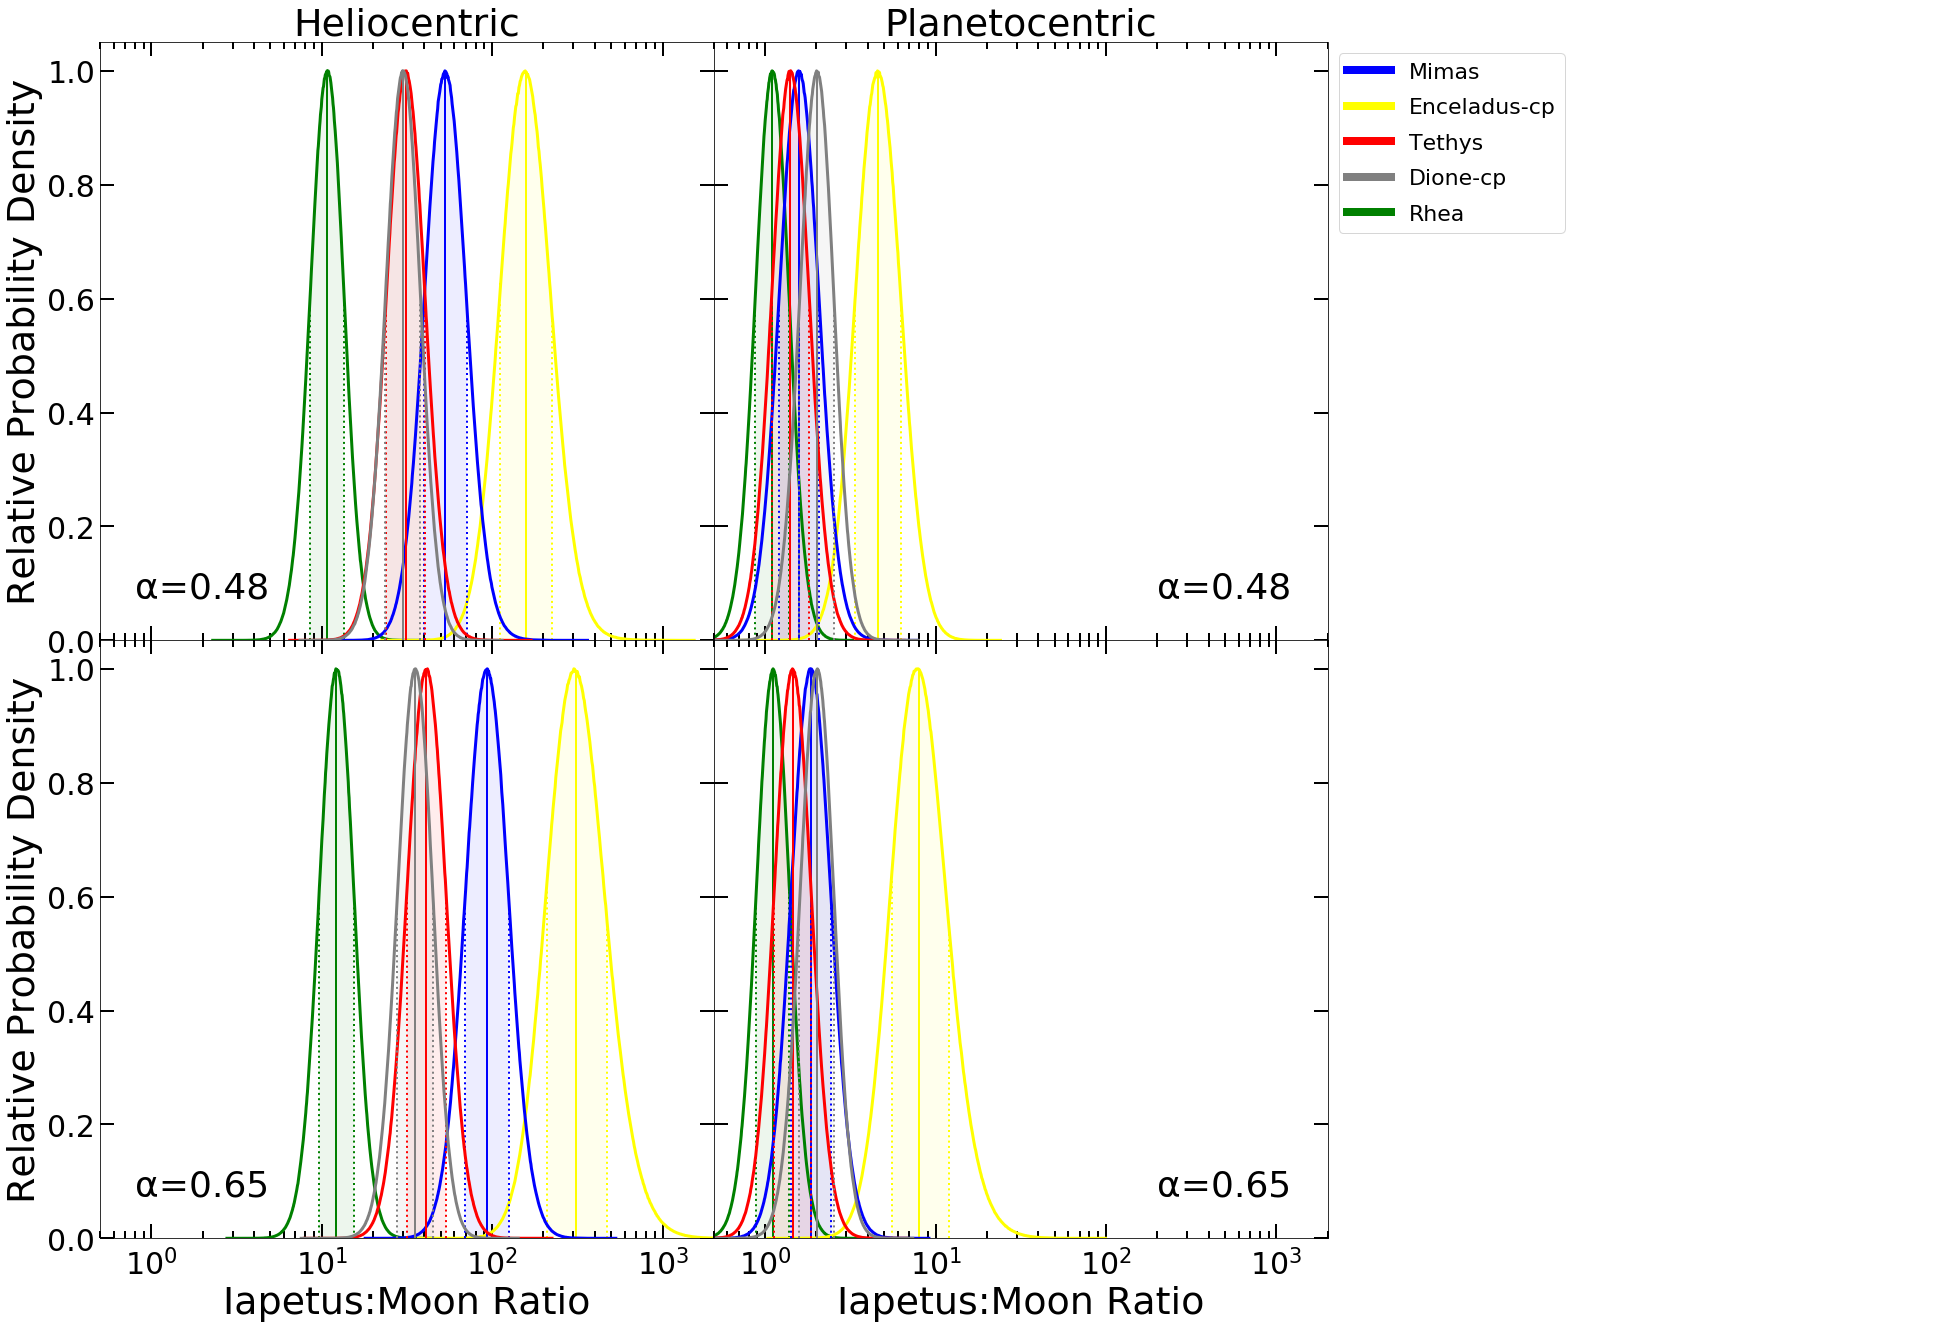

In [506]:
plt.rcParams['errorbar.capsize'] = 12
title_list = ['Heliocentric','Planetocentric','','','','']
ir_dict_list = [ir_h48_dict,ir_p48_dict,'',ir_h65_dict,ir_p65_dict,'']
fig = plt.figure(figsize=(33,22))
for i in list(range(6)):
    if i%3!=2:
        ax = fig.add_subplot(231 + i)
        ir_dict = ir_dict_list[i]
        plt.rcParams['errorbar.capsize'] = 12
        #plt.rcParams['lines.linewidth'] = 4
        #ax = plot_iapetus_fraction(ir_dict,'Rhea')
        for key in set(cp_keys)-{'Iapetus-bright'}:
            plot_iapetus_fraction(ir_dict,key,ax=ax,do_print=False)
        plt.xlabel('Iapetus:Moon Ratio',size=22)
        plt.xticks(size=30)
        if i%3==0:
            plt.yticks(size=30)
            plt.ylabel('Relative Probability Density',size=38)
        else:
            ax.get_yaxis().set_ticklabels([])
            plt.ylabel('',size=1)
        plt.xlabel('Iapetus:Moon Ratio',size=38)
        plt.title(title_list[i],size=38)
        if i%3==0:
            x_pos=0.8
        else:
            x_pos=200
        if i < 3:
            plt.text(x_pos,0.075,'α=0.48',fontsize=36)
        else:
            plt.text(x_pos,0.075,'α=0.65',fontsize=36)
    elif i==2:
        ax = fig.add_subplot(231 + i)
        custom_lines = [Line2D([0], [0], color=color_dict[key], lw=8) for key in cp_keys[:-1]]
        ax.legend(custom_lines, cp_keys[:-1],labelspacing=0.7, fontsize=22, loc=2)
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticklabels([])
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=14, width=2)
    ax.get_xaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_yaxis().set_tick_params(length=14, width=2)
    ax.get_yaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_xaxis().set_ticks_position('both')
    ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(pad=10, which='both')
    ax.get_yaxis().set_tick_params(pad=5, which='both')
    
fig.subplots_adjust(wspace=0,hspace=0)

fig=plt.gcf()
fig.savefig('IapetusRatioPanel.pdf', bbox_inches='tight')

Plots a panel showing the crater density ratio PDFs and linear regressions for Mimas and Titan.  Figure 2.

(0.7947171574773053, 2.9763596862220627, 12.673018308609349)
(0.044533849613750585, 0.13744201447751586, 0.42264730011273743)
(2.14778863197633, 7.873830780625934, 31.337977694508954)
(0.04528633742107359, 0.14057726608178467, 0.4356495277501635)
(0.5238969852817692, 1.309957623699848, 2.8208669257356584)
(0.023730171236898565, 0.05851247520458232, 0.12293914519891407)
(1.006179566895188, 2.523251920284175, 5.45095282321332)
(0.023786006408477355, 0.05855958246935217, 0.12289092742616342)
Run time: 186.86


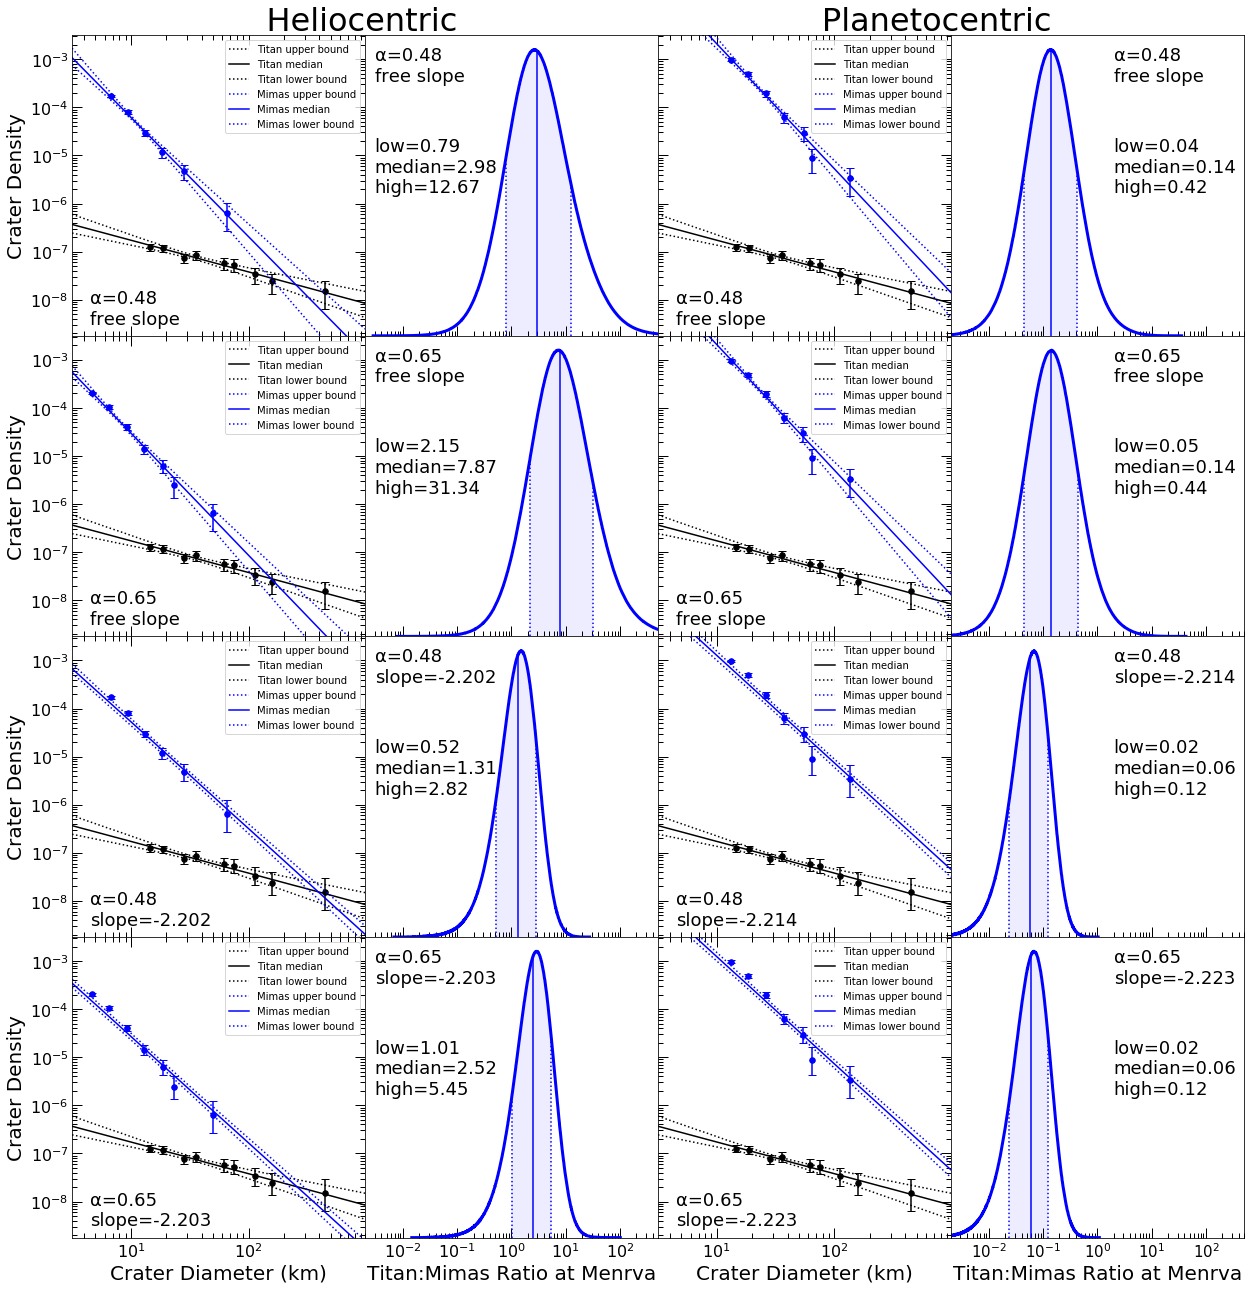

In [183]:
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['errorbar.capsize'] = 4
t1 = time.time()
n=10000
fig = plt.figure(figsize=(21,20))
for i in list(range(16)):
    if i%8<4:
        alpha = '0.48'
        if i%4<2:
            binned_dict = binned_dict_h48
            bs_dict = bs_h48_dict
            mean_m = mean_h48_m
        else:
            binned_dict = binned_dict_p48
            bs_dict = bs_p48_dict
            mean_m = mean_p48_m
    else:
        alpha = '0.65'
        if i%4<2:
            binned_dict = binned_dict_h65
            bs_dict = bs_h65_dict
            mean_m = mean_h65_m
        else:
            binned_dict = binned_dict_p65
            bs_dict = bs_p65_dict
            mean_m = mean_p65_m
    ax = fig.add_subplot(4,4,1 + i)
    if i%2==0:
        if i < 8:
            mstr = '\nfree slope'
            plot_moon_lines(binned_dict,'Mimas',n,ax=ax,do_legend=True)
        else:
            mstr = '\nslope='+str(round(mean_m,3))
            plot_mean_m_lines(bs_dict,binned_dict,'Mimas',ax=ax,do_legend=True)
        plt.xlabel('Crater Diameter (km)',size=20)
        plt.ylabel('Crater Density',size=20)
        plt.text(4.5,10**-8.5,'α='+alpha+mstr,fontsize=18)
    if i%4>1:
        ax.get_yaxis().set_ticklabels([])
        plt.ylabel('',size=1)
    if i%2==1:
        if i < 8:
            low1,med1,high1 = plot_age_fraction(binned_dict,'Mimas',n,ax=ax)
        else:
            low1,med1,high1 = plot_age_fraction_mean_m(bs_dict,'Mimas',ax=ax)
        ax.get_yaxis().set_ticklabels([])
        plt.xlabel('Titan:' + 'Mimas' + ' Ratio at Menrva',size=20)
        if i%4<=2:
            xpos = 0.003
        else:
            xpos = 2
        plt.text(xpos,0.89,'α='+alpha+mstr,fontsize=18)
        plt.text(xpos,0.5,'low='+str(round(low1,2))\
                 +'\nmedian='+str(round(med1,2))\
                 +'\nhigh='+str(round(high1,2)),fontsize=18)
        ax.get_yaxis().set_visible(False)
    else:
        ax.get_xaxis().set_ticks_position('both')
        ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=10, width=1)
    ax.get_xaxis().set_tick_params(length=5, width=1, which='minor')
    ax.get_yaxis().set_tick_params(length=10, width=1)
    ax.get_yaxis().set_tick_params(length=5, width=1, which='minor')
plt.xticks(size=15)
plt.yticks(size=15)
fig.suptitle('    Heliocentric' + 36*' ' + 'Planetocentric',size=32)
fig.subplots_adjust(wspace=0, hspace=0,top=0.96)
t2=time.time()
print('Run time: ' + str(round(t2-t1,2)))
fig=plt.gcf()
fig.savefig('TitanMimasAgeFractionPanel.pdf', bbox_inches='tight')

Plots a panel showing the planetocentric crater density ratio PDFs and linear regressions for Rhea, Iapetus, and Titan.  Figure 2.

(0.01201933079625916, 0.030607161923678086, 0.06847313728368934)
(0.013258688996093504, 0.033097591034263546, 0.07121957098866712)
(0.010525302382062268, 0.026750621438849712, 0.059671613435951634)
(0.011374658522811144, 0.02831211148831294, 0.06060767783235492)
(0.016314282277445087, 0.03936286125293631, 0.07979601689355512)
(0.014830131186663077, 0.035939305137147895, 0.07343634278576448)
(0.014250400217333635, 0.034438692404566026, 0.070029142580294)
(0.012837059661252932, 0.031071184057091552, 0.06340904029797934)
Run time: 191.73


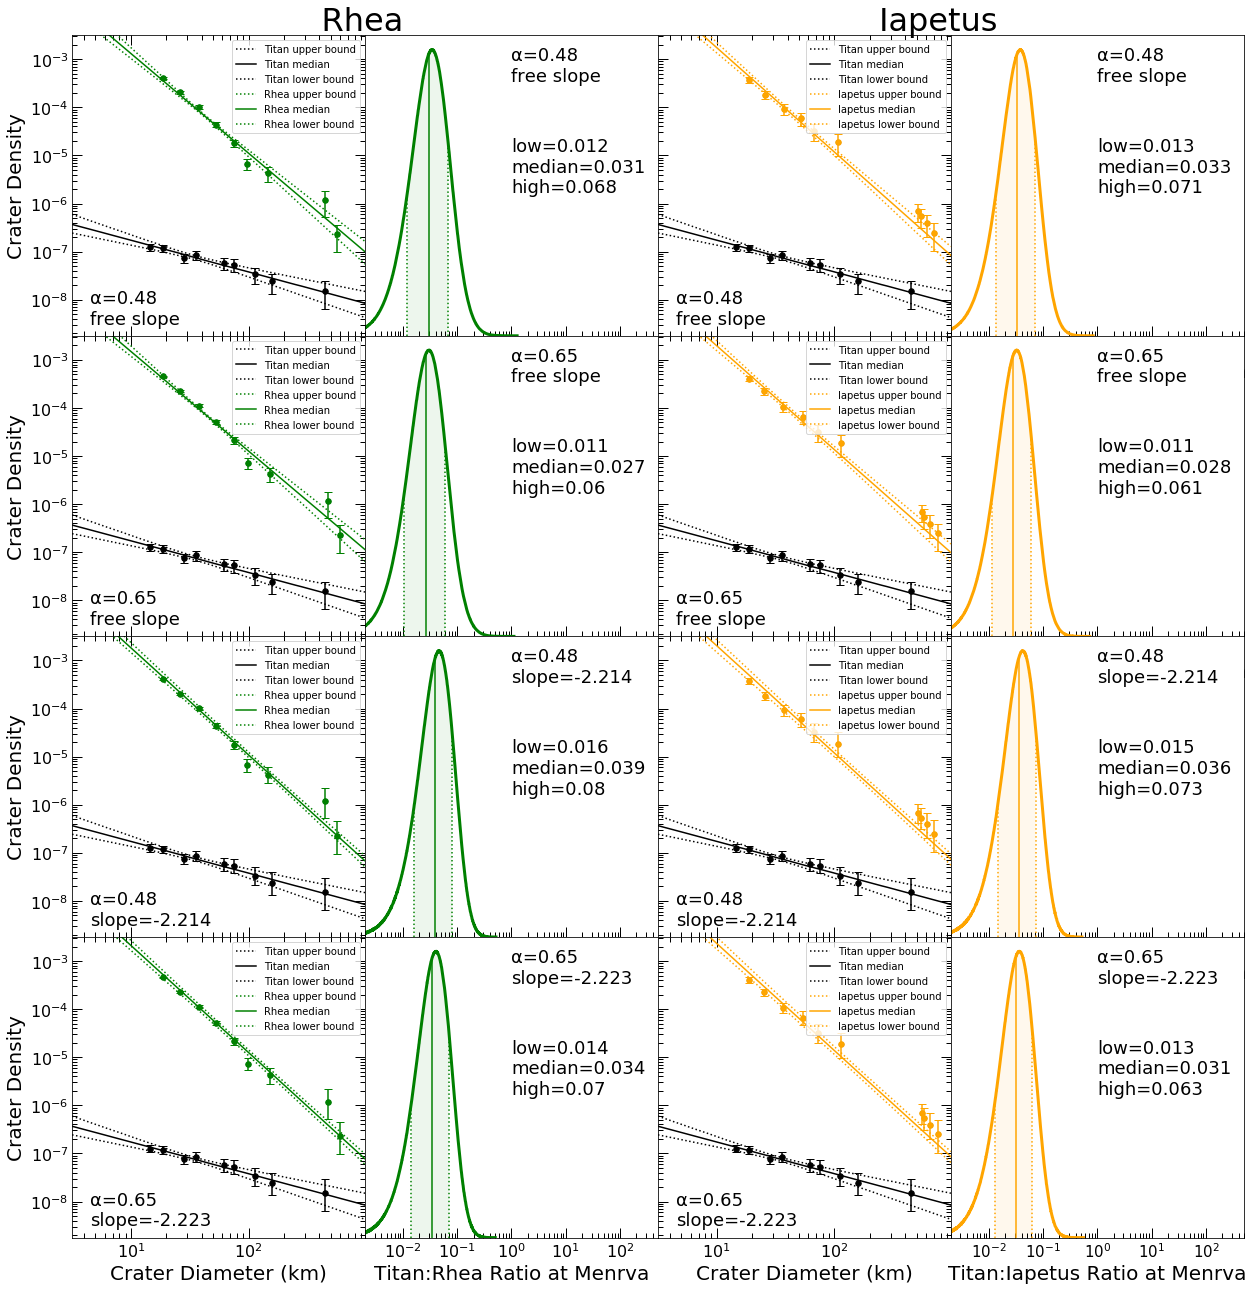

In [184]:
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['errorbar.capsize'] = 4
t1 = time.time()
n=10000
fig = plt.figure(figsize=(21,20))
for i in list(range(16)):
    if i%4<2:
        key='Rhea'
    else:
        key='Iapetus-bright'
    if i%8<4:
        alpha = '0.48'
        binned_dict = binned_dict_p48
        bs_dict = bs_p48_dict
        mean_m = mean_p48_m
    else:
        alpha = '0.65'
        binned_dict = binned_dict_p65
        bs_dict = bs_p65_dict
        mean_m = mean_p65_m
    ax = fig.add_subplot(4,4,1 + i)
    if i%2==0:
        if i < 8:
            mstr = '\nfree slope'
            plot_moon_lines(binned_dict,key,n,ax=ax,do_legend=True)
        else:
            mstr = '\nslope='+str(round(mean_m,3))
            plot_mean_m_lines(bs_dict,binned_dict,key,ax=ax,do_legend=True)
        plt.xlabel('Crater Diameter (km)',size=20)
        plt.ylabel('Crater Density',size=20)
        plt.text(4.5,10**-8.5,'α='+alpha+mstr,fontsize=18)
    if i%4>1:
        ax.get_yaxis().set_ticklabels([])
        plt.ylabel('',size=1)
    if i%2==1:
        if i < 8:
            low1,med1,high1 = plot_age_fraction(binned_dict,key,n,ax=ax)
        else:
            low1,med1,high1 = plot_age_fraction_mean_m(bs_dict,key,ax=ax)
        ax.get_yaxis().set_ticklabels([])
        plt.xlabel('Titan:' + key.partition('-')[0] + ' Ratio at Menrva',size=20)
        if i%4<=2:
            xpos = 1
        else:
            xpos = 1
        plt.text(xpos,0.89,'α='+alpha+mstr,fontsize=18)
        plt.text(xpos,0.5,'low='+str(round(low1,3))\
                 +'\nmedian='+str(round(med1,3))\
                 +'\nhigh='+str(round(high1,3)),fontsize=18)
        ax.get_yaxis().set_visible(False)
    else:
        ax.get_xaxis().set_ticks_position('both')
        ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=10, width=1)
    ax.get_xaxis().set_tick_params(length=5, width=1, which='minor')
    ax.get_yaxis().set_tick_params(length=10, width=1)
    ax.get_yaxis().set_tick_params(length=5, width=1, which='minor')
plt.xticks(size=15)
plt.yticks(size=15)
fig.suptitle('    Rhea' + 47*' ' + 'Iapetus',size=32)
fig.subplots_adjust(wspace=0, hspace=0,top=0.96)
t2=time.time()
print('Run time: ' + str(round(t2-t1,2)))
fig=plt.gcf()
fig.savefig('TitanRheaIapetusAgeFractionPanel.pdf', bbox_inches='tight')

While not used in the paper, this visualization demonstrates how the lower bound of the Menrva bin provides a stronger lower bound than the lower bounds of any other bins.  It shows how Menrva, despite its large N=1 error bars, is the strongest constraint on the lower bound of the age of Titan.

<Figure size 720x720 with 0 Axes>

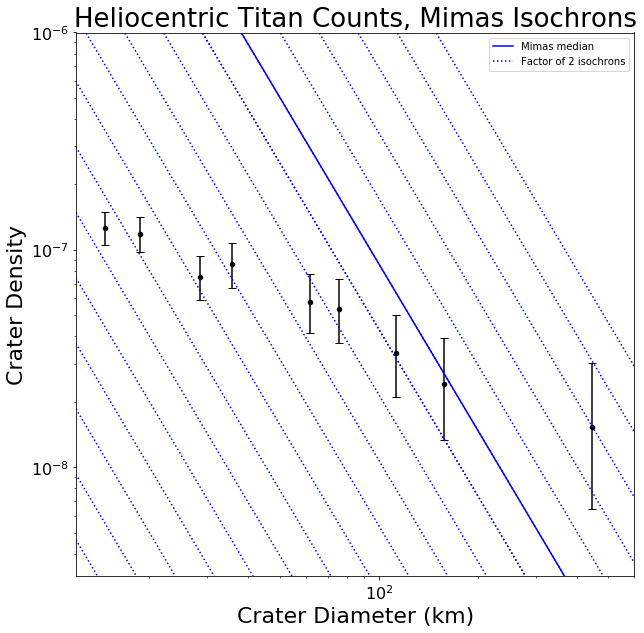

In [186]:
fig=plt.figure(figsize=(10,10))
key='Mimas'
moon_lines = get_lines(binned_dict_h65,key,n)
xe = np.arange(0.5,3,0.01)
mmimas = [10**get_percentile(moon_lines,xei,50.0) for xei in xe]
ax = binned_dict_h65[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter', color='white')
titan_data.plot(y='density', x='D', yerr=np.array([titan_data[['lower','upper']].values.transpose()]), color='black', \
                logx=True, logy=True, kind='scatter', ax=ax, figsize=(10,10))
pd.DataFrame({'1/' + str(2**i) + ' Mimas':np.array(mmimas)/2**i for i in list(range(-5,15))},index=[10**i for i in xe]).plot(\
                logx=True, logy=True, ax=ax, figsize=(10,10), color=color_dict[key],\
                style=':', legend=False)
pd.DataFrame({'Mimas median':mmimas},index=[10**i for i in xe]).plot(\
                logx=True, logy=True, ax=ax, figsize=(10,10), color=color_dict[key],\
                style='-', legend=True)
pd.DataFrame({'Factor of 2 isochrons':np.array(mmimas)/2},index=[10**i for i in xe]).plot(\
                logx=True, logy=True, ax=ax, figsize=(10,10), color=color_dict[key],\
                style=':', legend=True)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim([10**-8.5,10**-6])
plt.xlim([12,600])
plt.xlabel('Crater Diameter (km)',size=22)
plt.ylabel('Crater Density',size=22)
plt.title('Heliocentric Titan Counts, Mimas Isochrons',size=26)
fig.savefig('HeliocentricMimasIsochrons.pdf')

Define the function that prepares the data for the analysis based just on the largest crater on each moon.

In [187]:
def get_h1crater_dict(alpha):
    big_D_dict = {'Mimas':139.0, 'Tethys':445.0, 'Dione-cp':350,'Rhea':480,'Iapetus-bright':580.0,'Titan':titan_ds['D'][0]}
    i_e=3.5
    return_dict = dict()
    for key in big_D_dict.keys():
        full_area = r_dict[key]**2 * math.pi * 4 /1000000.0
        sf = d_scale_factor_h(0.05, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha)
        pt = pt_dict[key]
        gmeans_d = big_D_dict[key] * sf
        binned_d = ig_50(1.0)/full_area/pt
        binned_l = ig_lower(1.0)/full_area/pt
        binned_u = ig_upper(1.0)/full_area/pt
        binned_ndist = ig_ndist(1.0,i_e)/full_area/pt
        return_dict[key] = {'D_sf':gmeans_d, 'density_sf':binned_d, 'lower_sf':binned_l, 'upper_sf':binned_u, 'ndist_sf':binned_ndist}
    return return_dict

Process the data for the largest crater analysis.

In [188]:
h1crater_dict65 = get_h1crater_dict(0.65)
h1crater_dict48 = get_h1crater_dict(0.48)

Define a function for calculating the Iapetus ratios for the single-crater calculation.

In [514]:
def get_iapetus_ratio_h1crater_dict(h1crater_dict,mean_m_dist,n):
    mt1=time.time()
    print('Generating inputs...')
    t1=time.time()
    m_list = np.random.choice(mean_m_dist,n)
    t2=time.time()
    print('Inputs generated in: ' + str(round(t2-t1,3)) + ' s\nCalculating ratios...')
    bs_dict = {}
    for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Iapetus-bright','Titan'}:
        t1=time.time()
        x = h1crater_dict[key]['D_sf']
        y = np.log10(np.random.choice(h1crater_dict[key]['ndist_sf'],len(m_list)))
        bs = y - np.array(m_list) * log(x)
        bs_dict[key] = np.array(bs)
        t2=time.time()
        print(key.partition('-')[0] + ' b values calculated in: ' + str(round(t2-t1,3)) + ' s')
    ratio_dict = {}
    print('Dividing...')
    t1=time.time()
    for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Titan'}:
        ratio_dict[key] = 10**(bs_dict['Iapetus-bright']-bs_dict[key])
    t2=time.time()
    print('Divisions finished in: ' + str(round(t2-t1,3)) + ' s')
    mt2=time.time()
    print('Full run time: ' + str(round(mt2-mt1,3)) + ' s')
    return ratio_dict

Calculate the Iapetus ratios for the single-crater calculation.

In [520]:
if False:
    h1crater_ir_dict48 = get_iapetus_ratio_h1crater_dict(h1crater_dict48,mean_h48_m_dist,10000000)
    h1crater_ir_dict65 = get_iapetus_ratio_h1crater_dict(h1crater_dict65,mean_h65_m_dist,10000000)
    pkl.dump( h1crater_ir_dict48, open('h1crater_ir_dict48.pkl', 'wb'))
    pkl.dump( h1crater_ir_dict65, open('h1crater_ir_dict65.pkl', 'wb'))
else:
    h1crater_ir_dict48 = pkl.load(open('h1crater_ir_dict48.pkl', 'rb'))
    h1crater_ir_dict65 = pkl.load(open('h1crater_ir_dict65.pkl', 'rb'))

Calculate the lower bound on the Iapetus:Mimas ratio in the single-crater calculation.

In [521]:
np.percentile(h1crater_ir_dict48['Mimas'],100-84.1345)

42.821437329698306

Plot crater age ratios based entirely on the observation of a single crater.  Supplemental Figure D1.

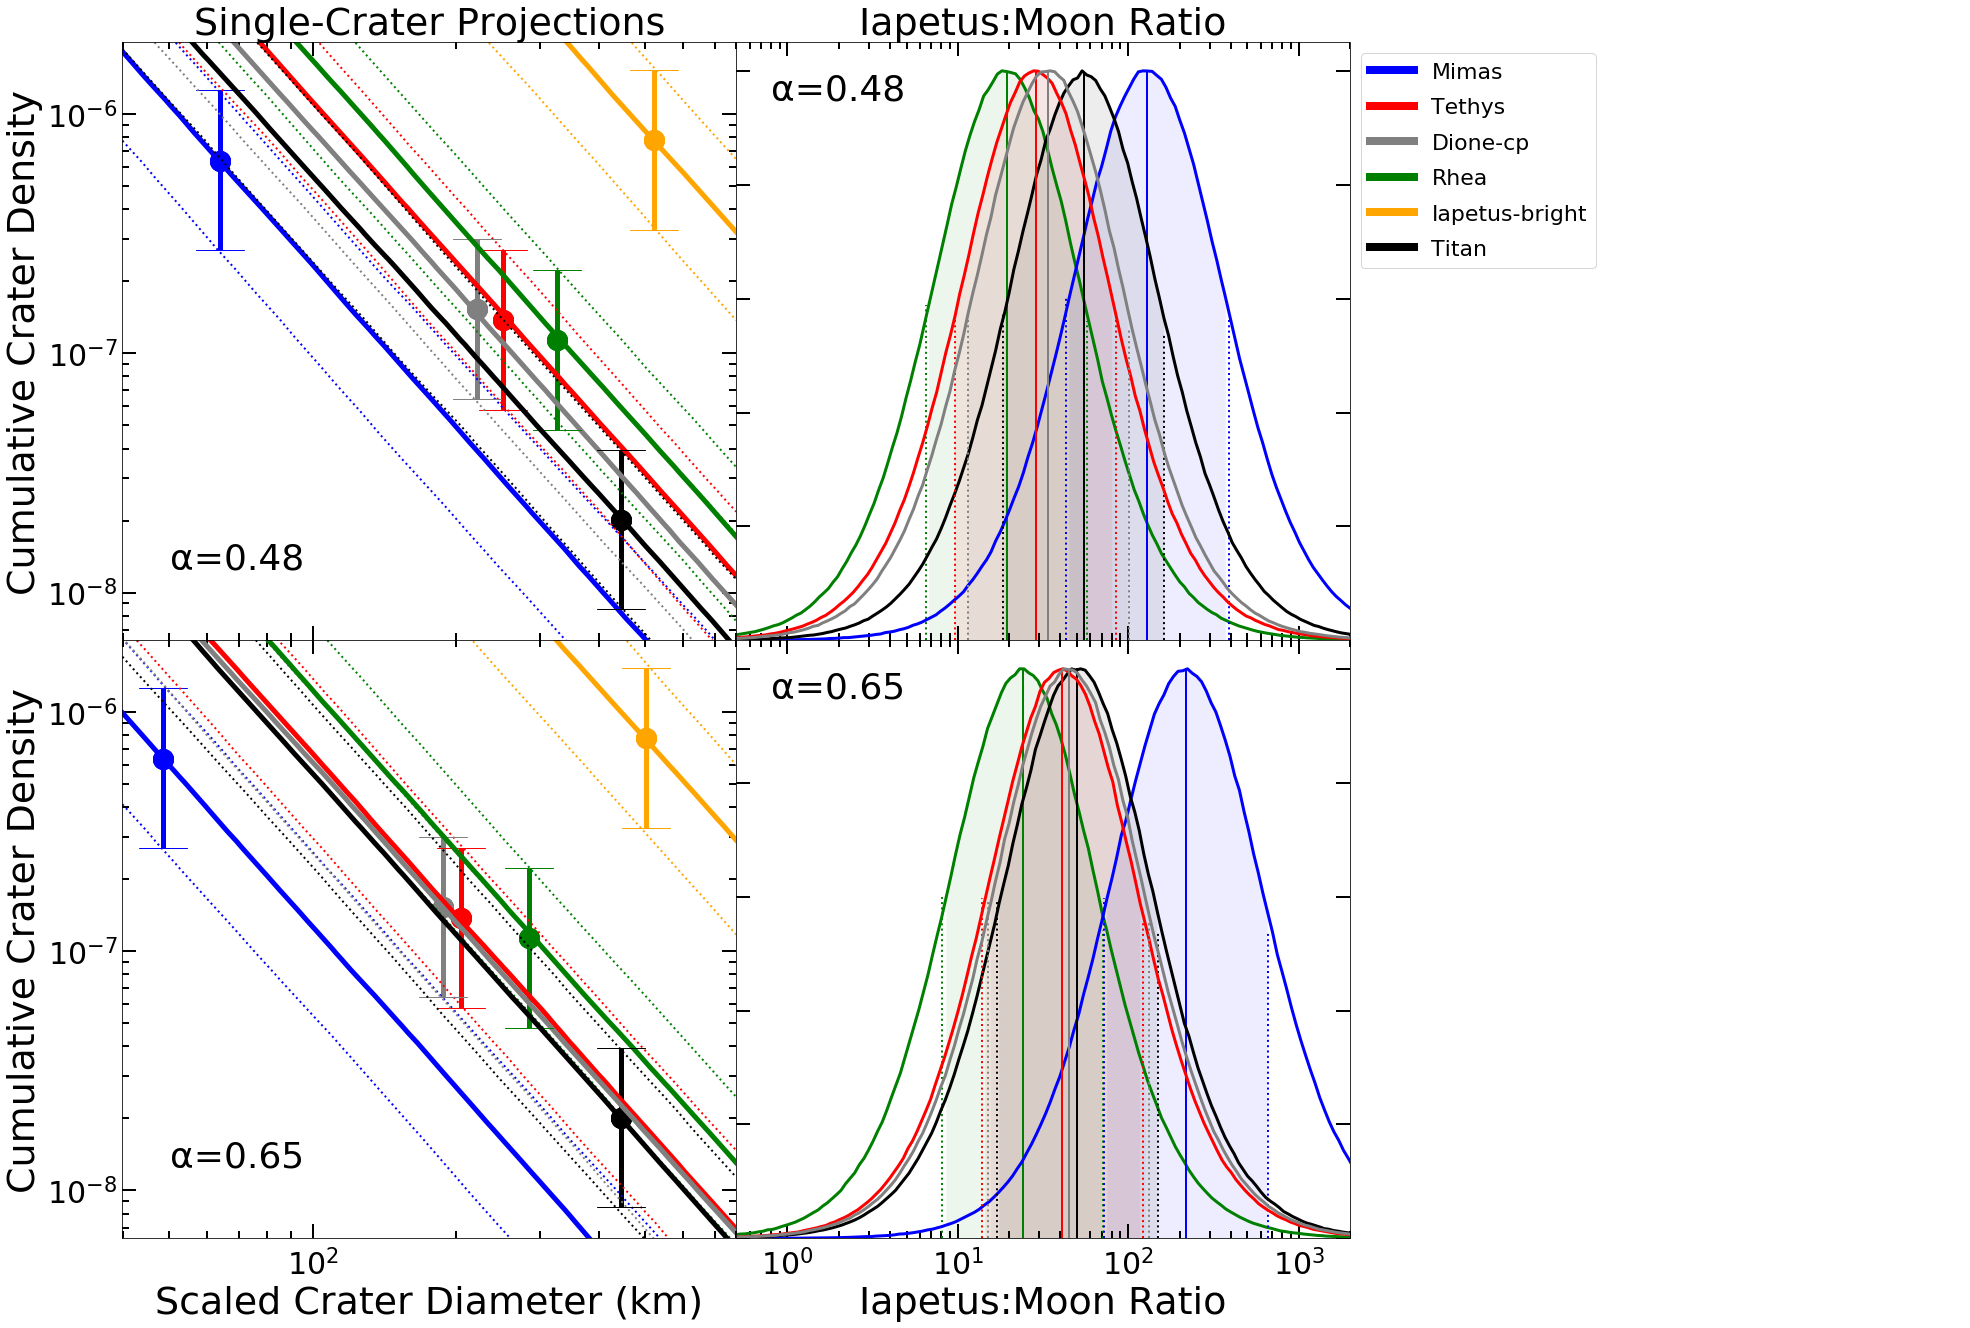

In [518]:
plt.rcParams['errorbar.capsize'] = 12
title_list = ['Single-Crater Projections','Iapetus:Moon Ratio','','','','']
ir_dict_list = ['',h1crater_ir_dict48,'','',h1crater_ir_dict65,'']
fig = plt.figure(figsize=(33,22))
key_list = ['Mimas', 'Tethys', 'Dione-cp','Rhea','Iapetus-bright','Titan']
for i in list(range(5)):
    if i%3==1:
        ax = fig.add_subplot(231 + i)
        ir_dict = ir_dict_list[i]
        plt.rcParams['errorbar.capsize'] = 12
        plt.rcParams['lines.linewidth'] = 2
        for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Titan'}:
            plot_iapetus_fraction(ir_dict,key,ax=ax,do_print=False,n_bins=200)
        plt.xticks(size=30)
        ax.get_yaxis().set_ticklabels([])
        plt.ylabel('',size=1)
        plt.xlabel('Iapetus:Moon Ratio',size=38)
        plt.title(title_list[i],size=38)
        if i < 3:
            plt.text(0.8,0.95,'α=0.48',fontsize=36)
        else:
            plt.text(0.8,0.95,'α=0.65',fontsize=36)
    elif i%3==0:
        ax = fig.add_subplot(231 + i)
        if i==0:
            alpha_str = '48'
            mean_m_dist = mean_h48_m_dist
            h1crater_dict = h1crater_dict48
        elif i==3:
            alpha_str = '65'
            mean_m_dist = mean_h65_m_dist
            h1crater_dict = h1crater_dict65
        for key in key_list:
            bs = []
            x = h1crater_dict[key]['D_sf']
            n = 1000
            for j in list(range(n)):
                y = log(random.choice(h1crater_dict[key]['ndist_sf']))
                m = np.random.choice(mean_m_dist)
                b = y - m * log(x)
                bs.append((m,b))

            xe = np.arange(1.6,2.9,0.01)
            mmoon = [np.median([10**(m*xei + b) for m,b in bs]) for xei in xe]
            umoon = [np.percentile([10**(m*xei + b) for m,b in bs], 84.1345) for xei in xe]
            lmoon = [np.percentile([10**(m*xei + b) for m,b in bs], 100.0-84.1345) for xei in xe]
            pd.DataFrame({key.partition('-')[0] + ' upper bound':umoon, key.partition('-')[0] + ' median':mmoon, \
                          key.partition('-')[0] + ' lower bound':lmoon},index=[10**i for i in xe]).plot(\
                                logx=True, logy=True, ax=ax, color=color_dict[key],\
                                style=[':','-',':'], legend=False,lw=2)
            pd.DataFrame({key.partition('-')[0] + ' median':mmoon},index=[10**i for i in xe]).plot(\
                                logx=True, logy=True, ax=ax, color=color_dict[key],\
                                style=['-'], legend=False,lw=5)
            plt.rcParams['lines.linewidth'] = 5
            plt.rcParams['errorbar.capsize'] = 24
            pd.DataFrame(h1crater_dict[key]).iloc[:3].plot(y='density_sf',x='D_sf',
                    yerr=np.array([pd.DataFrame(h1crater_dict[key]).iloc[:3][['lower_sf','upper_sf']].values.transpose()]), 
                    logx=True, logy=True, kind='scatter', 
                    ax=ax, color=color_dict[key], legend=False, s=400)
            plt.rcParams['lines.linewidth'] = 2
            plt.rcParams['errorbar.capsize'] = 12
        plt.text(10**1.7,10**-7.9,'α=0.' + alpha_str,fontsize=36)
        plt.xticks(size=30)
        plt.yticks(size=30)
        plt.ylim([10**-8.2,10**-5.7])
        plt.xlabel('Scaled Crater Diameter (km)',size=38)
        plt.ylabel('Cumulative Crater Density',size=38)
        plt.title(title_list[i],size=38)

    elif i==2:
        ax = fig.add_subplot(231 + i)
        custom_lines = [Line2D([0], [0], color=color_dict[key], lw=8) for key in key_list]
        ax.legend(custom_lines, key_list,labelspacing=0.7, fontsize=22, loc=2)
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticklabels([])
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=14, width=2)
    ax.get_xaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_yaxis().set_tick_params(length=14, width=2)
    ax.get_yaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_xaxis().set_ticks_position('both')
    ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(pad=10, which='both')
    ax.get_yaxis().set_tick_params(pad=5, which='both')
    
fig.subplots_adjust(wspace=0,hspace=0)

fig=plt.gcf()
fig.savefig('OneCraterSaturationPanel.pdf', bbox_inches='tight')

This calculates the crater diameter equivalent to a destruction scale impact by scaling the destruction conditions of Mimas calculated by Charnoz et al. (2009) to a hypothetical crater diameter using Equation 5 of Zahnle et al. (2003).

In [254]:
Ds = 11.9 * (32**2/(100*G*m_mimas/r_mimas**2))**0.217 * (2/3)**0.333 * 17**0.783
D_destruction = Ds * (Ds/15)**0.13
D_destruction

422.3486366636343

Calculate the PDF of the number of craters large enough to destroy Mimas if Herschel crater were in equilibrium saturation and were saturated so many times over that it had entirely erased the scaled heliocentric crater density difference with Iapetus, extrapolated out from the observation of Herschel crater.  Calculations for Supplement E.

In [256]:
mt1=time.time()
t1=time.time()
mimas_area = r_mimas**2 * math.pi * 4 /1000000.0
herschel_ndist = ig_ndist(1,4)
t2=time.time()
print('herschel_ndist run time: ' + str(round(t2-t1,2)) + ' s')
if False:
    n_samples = 100000000
    t1=time.time()
    herschel_dist = 10**(log(422.3486366636343/139.0)*-3) * np.random.choice(herschel_ndist, n_samples)\
              * np.random.choice(ir_h48_dict['Mimas'], n_samples)
    ti=time.time()
    print('First step run time: ' + str(round(ti-t1,2)) + ' s')
    herschel_percentiles_3 = np.percentile(herschel_dist,np.arange(0.00005,100.0,0.00005))
    t2=time.time()
    print('Total run time for b=-3: ' + str(round(t2-t1,2)) + ' s')
    t1=time.time()
    herschel_dist = 10**(log(422.3486366636343/139.0)*-2.5) * np.random.choice(herschel_ndist, n_samples)\
              * np.random.choice(ir_h48_dict['Mimas'], n_samples)
    ti=time.time()
    print('First step run time: ' + str(round(ti-t1,2)) + ' s')
    herschel_percentiles_2p5 = np.percentile(herschel_dist,np.arange(0.00005,100.0,0.00005))
    t2=time.time()
    print('Total run time for b=-2.5: ' + str(round(t2-t1,2)) + ' s')
    t1=time.time()
    herschel_dist = 10**(log(422.3486366636343/139.0)*-2) * np.random.choice(herschel_ndist, n_samples)\
              * np.random.choice(ir_h48_dict['Mimas'], n_samples)
    ti=time.time()
    print('First step run time: ' + str(round(ti-t1,2)) + ' s')
    herschel_percentiles_2 = np.percentile(herschel_dist,np.arange(0.00005,100.0,0.00005))
    t2=time.time()
    print('Total run time for b=-2: ' + str(round(t2-t1,2)) + ' s')
    pkl.dump( herschel_percentiles_3, open('herschel_percentiles_3.pkl', 'wb'))
    pkl.dump( herschel_percentiles_2p5, open('herschel_percentiles_2p5.pkl', 'wb'))
    pkl.dump( herschel_percentiles_2, open('herschel_percentiles_2.pkl', 'wb'))
else:
    herschel_percentiles_3 = pkl.load(open('herschel_percentiles_3.pkl', 'rb'))
    herschel_percentiles_2p5 = pkl.load(open('herschel_percentiles_2p5.pkl', 'rb'))
    herschel_percentiles_2 = pkl.load(open('herschel_percentiles_2.pkl', 'rb'))
mt2=time.time()
print('Total run time: ' + str(round(mt2-mt1,2)) + ' s')

herschel_ndist run time: 2.11 s
Total run time: 2.24 s


Define a function to calculate the destruction probability of Mimas.

In [202]:
def calc_destruction_prob(herschel_percentiles):
    guess_1 = np.arange(0,100,1)[abs(np.percentile(herschel_percentiles,np.arange(0,100,1))-1).argmin()]
    guess_2 = np.arange(max(guess_1-1.2,0),min(guess_1+1.2,100),0.1)[abs(np.percentile(herschel_percentiles,\
                            np.arange(max(guess_1-1.2,0),min(guess_1+1.2,100),0.1))-1).argmin()]
    guess_3 = np.arange(max(guess_2-0.12,0),min(guess_2+0.12,100),0.01)[abs(np.percentile(herschel_percentiles,\
                            np.arange(max(guess_2-0.12,0),min(guess_2+0.12,100),0.01))-1).argmin()]
    guess_4 = np.arange(max(guess_3-0.012,0),min(guess_3+0.012,100),0.001)[abs(np.percentile(herschel_percentiles,\
                            np.arange(max(guess_3-0.012,0),min(guess_3+0.012,100),0.001))-1).argmin()]
    guess_5 = np.arange(max(guess_4-0.0012,0),min(guess_4+0.0012,100),0.0001)[abs(np.percentile(herschel_percentiles,\
                            np.arange(max(guess_4-0.0012,0),min(guess_4+0.0012,100),0.0001))-1).argmin()]
    return 100-guess_5

Plot the PDFs of the number of impacts large enough to destroy Mimas.  Supplemental Figure E1.

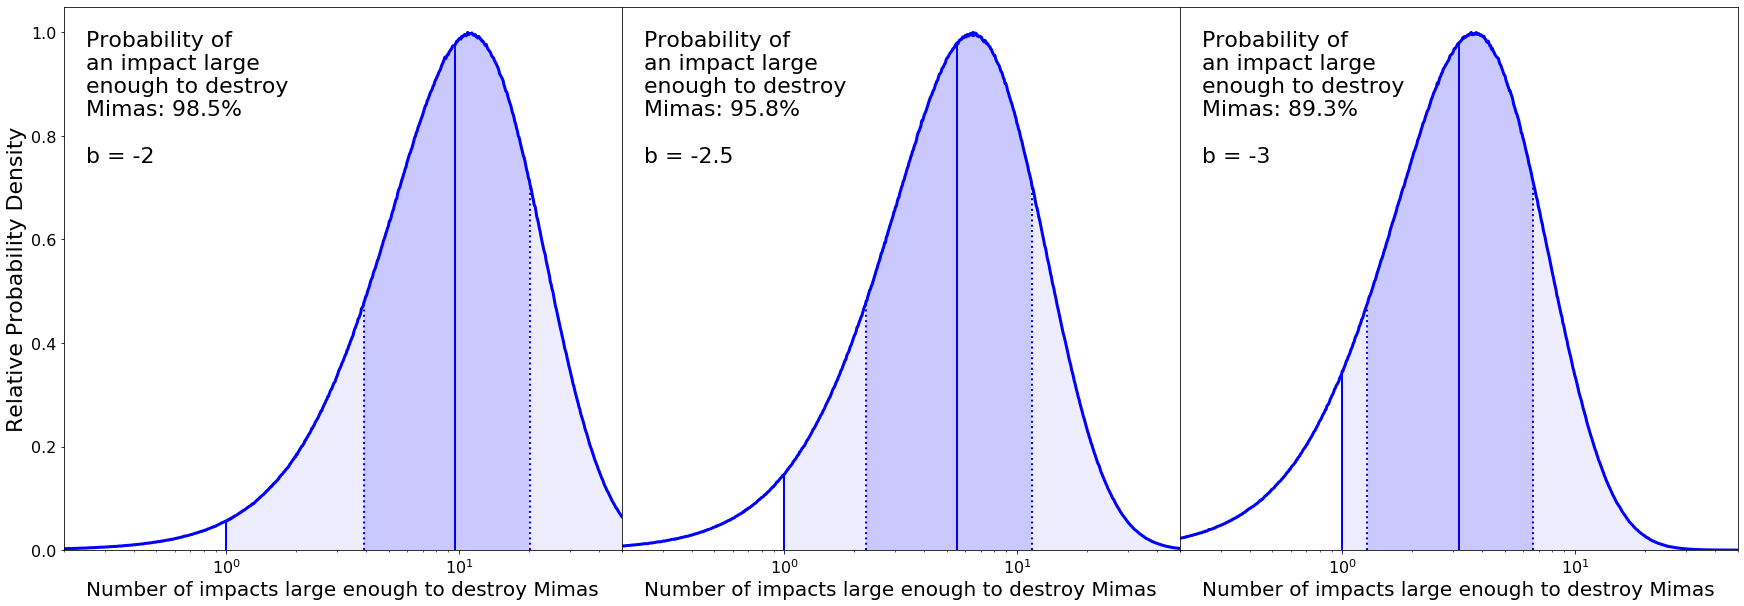

In [252]:
herschel_percentiles = herschel_percentiles_2
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(131)
Y,bin_edges=np.histogram(np.log10(herschel_percentiles),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X = np.array([np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))])
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(herschel_percentiles,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.15)
ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
ax.semilogx([1,1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > 1)]],color=color_dict['Mimas'])
ax.fill_between(X,0,Y, where=(1.0<X), facecolor=color_dict['Mimas'], alpha=0.07)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Number of impacts large enough to destroy Mimas',size=20)
plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.2,50])
plt.ylim([0,1.05])
plt.text(0.25,0.75,'Probability of\nan impact large\nenough to destroy\nMimas: ' + \
         str(round(calc_destruction_prob(herschel_percentiles),1))\
         + '%\n\nb = -2',fontsize=22)
#pfig = plt.gcf()
#pfig.savefig('herschel_probabilities_3.pdf',bbox_inches='tight')

herschel_percentiles = herschel_percentiles_2p5
#fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(132)
Y,bin_edges=np.histogram(np.log10(herschel_percentiles),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X = np.array([np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))])
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(herschel_percentiles,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.15)
ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
ax.semilogx([1,1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > 1)]],color=color_dict['Mimas'])
ax.fill_between(X,0,Y, where=(1.0<X), facecolor=color_dict['Mimas'], alpha=0.07)
plt.xticks(size=16)
plt.yticks([])
plt.xlabel('Number of impacts large enough to destroy Mimas',size=20)
#plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.2,50])
plt.ylim([0,1.05])
plt.text(0.25,0.75,'Probability of\nan impact large\nenough to destroy\nMimas: ' + \
         str(round(calc_destruction_prob(herschel_percentiles),1))\
         + '%\n\nb = -2.5',fontsize=22)
#pfig = plt.gcf()
#pfig.savefig('herschel_probabilities_2p5.pdf',bbox_inches='tight')

herschel_percentiles = herschel_percentiles_3
#fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(133)
Y,bin_edges=np.histogram(np.log10(herschel_percentiles),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X = np.array([np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))])
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(herschel_percentiles,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.15)
ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
ax.semilogx([1,1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > 1)]],color=color_dict['Mimas'])
ax.fill_between(X,0,Y, where=(1.0<X), facecolor=color_dict['Mimas'], alpha=0.07)
plt.xticks(size=16)
plt.yticks([])
plt.xlabel('Number of impacts large enough to destroy Mimas',size=20)
#plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.2,50])
plt.ylim([0,1.05])
plt.text(0.25,0.75,'Probability of\nan impact large\nenough to destroy\nMimas: ' + \
         str(round(calc_destruction_prob(herschel_percentiles),1))\
         + '%\n\nb = -3',fontsize=22)
fig.subplots_adjust(wspace=0,hspace=0)
pfig = plt.gcf()
pfig.savefig('herschel_probabilities.pdf',bbox_inches='tight')

Define the De Sisto and Zanardi (2016) cratering rate decay functions.

In [244]:
def age_fraction(t):
    return 0.198406*math.log(t)-3.41872

def get_age_from_fraction(fraction):
    return 4.5*10**9-math.e**((fraction + 3.41872)/0.198406)

Calculate the expected age of the cratered plains of Rhea using the De Sisto and Zanardi (2016) cratering rate decay functions, assuming no heavy bombardment and an Iapetus bright terrain age of 4.5Ga.

In [270]:
get_age_from_fraction(1-1/np.percentile(ir_h48_dict['Rhea'],100-84.1345))

1902334228.893969

Calculate the expected age of the cratered plains of Mimas using the De Sisto and Zanardi (2016) cratering rate decay functions, assuming no heavy bombardment and an Iapetus bright terrain age of 4.5Ga.

In [268]:
get_age_from_fraction(1-1/np.percentile(ir_h48_dict['Mimas'],100-84.1345))

351991038.973228

Calculations for numbers used in the paper

In [511]:
print(np.percentile(ir_h48_dict['Mimas'],[100-84.1345,50,84.1345]))
print(np.percentile(ir_h65_dict['Mimas'],[100-84.1345,50,84.1345]))

[40.03794514 53.19603978 70.93627969]
[ 69.56958111  93.21077417 125.03992606]


In [522]:
np.mean([53.19603978,93.21077417])

73.203406975